In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

#homemade function file
import importlib
import ppe_loading_functions #as functions
importlib.reload(ppe_loading_functions)
import ref_data_functions #as functions
importlib.reload(ref_data_functions)

from pylab import cm
import netCDF4
import numpy as np
from netCDF4 import Dataset

#HM
import pickle
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score
import random

In [2]:
var1stPPE, results1stPPE,var2ndPPE, results2ndPPE, varMoreCloudParam, resultsMoreCloudParam,\
 varMoreCloudParam2, resultsMoreCloudParam2, varPhyDyn_NewParam_2tun,resultsPhyDyn_NewParam_2tun,\
 varPhyDyn_NewParam_5thPPE_2tun,results_5thPPE_2tun=\
ppe_loading_functions.load_all_ppes()

In [3]:
#Ref tuned ICON-A 2.6.4
pressure_addi,pressure_fact,tauufact,aes_glo_psl,aes_SOO_tauu,aes_NAO_tauu,aes_60N_1000hPa_ua,aes_60S_1000hPa_ua,\
aes_60N_10hPa_ua,aes_60S_10hPa_ua=ref_data_functions.ICON_aes_refdata()

In [4]:
#Physics Ref
ref_mean, ref_std=ref_data_functions.References_outputs()
#Dynamics Ref
refsERA5, refsMERRA2, refsERAInterim=ref_data_functions.References_Dynoutputs()

#all ref values for Physics and Dynamic variables
ref2tun_mean=np.zeros(9)
ref2tun_mean[0:5]=ref_mean #physics variables
ref2tun_mean[5:]=[refsERA5[0],refsERA5[1],refsERA5[2],refsERA5[3]] #dynamics variables
#ref_mean
print(ref2tun_mean)

#all std for Physics and Dynamic variables: not used yet in the HM flow

/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOALW=-file['gtoa_lw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarnin

[ 2.40866470e+02 -2.40114889e+02  5.00000000e-01  6.74343643e+01
  2.44086728e+01  1.09413767e+01  3.27732849e+01  2.94719753e-03
  1.36748120e-01]


In [5]:
ref_Clt_ESACCI, ref_Clt_ESACCI_std, ref_Clt_CLARA_AVHRR, ref_Clt_CLARA_AVHRR_std=ref_data_functions.Ref_clt()
ref_Prw_ESACCI, ref_Prw_ERA5, ref_Prw_ERA5_std=ref_data_functions.Ref_prw()

In [6]:
years_clt_esacci,clt_esacci_per_year=ref_data_functions.clt_esacci_per_years()
years_clt_claraavhrr,clt_claraavhrr_per_year=ref_data_functions.clt_claraavhrr_per_years()
years_prw_era5,prw_era5_per_year=ref_data_functions.prw_era5_per_years()

# Emulator training and performance

In [7]:
#Physics parameters then needs HM
#bounds enlarged for HM
#Emid_bounds = [2e-5, 3e-4] #not in the PhyDyn PPEs
iEpen_bounds = [2e-4, 6e-4] # default value used before is 3.0e-4
iR0top_bounds = [5e-1, 9e-1] # default value used before is 0.8
iCprcon_bounds = [0.00015 , 0.00035] # default value used before is 2.5e-4
iCvtfall_bounds = [0.2 , 4] # default value used before is 2.5
boundsPhy=[iEpen_bounds,iR0top_bounds,iCprcon_bounds,iCvtfall_bounds]
#additional physics parameters
crs_bounds = [0.75*0.968,0.99] #default value used before is 0.968 in src/configure_model/echam_cov_config.f90
csatsc_bounds = [0.7*0.5,0.7*1.5] #default value used before is 0.7 in src/configure_model/echam_cov_config.f90

#Dynamic parameters (same in all notebooks) 
iCd_bounds = [ 0.001, 0.09 ] #default value used in 1st tuning step 0.05 gkwake  = CdCdCd
iG_bounds = [ 0.002, 0.28 ] #default value used in 1st tuning step 0.05 gkdrag  = GGG
isTI_bounds = [ 0.647, 1.079 ] #[ 0.1, 2 ]  # NEW FOR 3rd PhyDyn PPE 0.87/8,0.87*8-> 7 too large, so down to 2 max [ 0.647, 1.079 ] #default value used in 1st tuning step 0.87 rmscon  = sTIsTIsTI
bounds_Dyn2PPE=[iCd_bounds,iG_bounds,isTI_bounds]
#additional dynamic parameters
igpicmea_bounds =[20,60] #[5,320] # NEW FOR 3rd PhyDyn PPE [40/8,40*8] [20,60]#40*0.5,40*1.5 default value used before 40 in src/configure_model/mo_echam_sso_config.f90
igstd_bounds = [5,15] #[1.25,80] # NEW FOR 3rd PhyDyn PPE 10/8,10*8 #[5,15]#10*0.5,10*1.5 default value used before 10 in src/configure_model/mo_echam_sso_config.f90
#iemiss_lev_bounds = [10]#[23:38]#10*0.5,10*1.5 /!\ need to take integers ! default value used before 10 # can use any levels such as 5,6,7,8,9,10,11,12,13,14,15?

boundsPhyDyn=[iEpen_bounds,iR0top_bounds,iCprcon_bounds,iCvtfall_bounds,iCd_bounds,iG_bounds,isTI_bounds]
boundsPhyDyn_newParam=[iEpen_bounds,iR0top_bounds,iCvtfall_bounds,crs_bounds,csatsc_bounds,iCd_bounds,iG_bounds,isTI_bounds,igpicmea_bounds,igstd_bounds]#,iemiss_lev_bounds]


In [8]:
# train the GP on the training sample - only phy parameters
def score_1st_tuning_step(varr,resultss):
            
    randsamples={}

    kernel = 1 * Matern(length_scale=1.0)#, nu=1.5) #RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) #np.array([1.0,1.0,1.0])) #length_scale=10) # ,1.0,1.0,1.0]))#, length_scale_bounds=(1e-2, 1e2))
    gaussian_process_multi = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=100)#,alpha=1e-5, n_restarts_optimizer=20)

    #scale data https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
    scaler_var1_2tun = preprocessing.StandardScaler().fit(varr,)
    scaled_var1_2tun = scaler_var1_2tun.transform(varr)

    Ntot=59 # total size of the sample
    sizeRes_60=np.arange(20,59,4) #[10,15,20,25,30,35,40,45,50,55]
    Nrand=5 # number of times we pick a sample of a given size
    score_isize_60=np.zeros((np.size(sizeRes_60),Nrand))
    score_isize_60_max=np.zeros((np.size(sizeRes_60)))
    score_isize_60_min=np.zeros((np.size(sizeRes_60)))
    score_isize_60_mean=np.zeros((np.size(sizeRes_60)))
    score_isize_60_std=np.zeros((np.size(sizeRes_60)))

    indSi=0
    for Sizz in sizeRes_60:
        indsam={}
        for irand in np.arange(0,Nrand):
            RandSamp=random.sample(range(1,Ntot),Sizz)
            indsam[irand]=RandSamp
            scaled_var1_2tun = scaler_var1_2tun.transform(varr[RandSamp])
            gaussian_process_multi.fit(scaled_var1_2tun, resultss[RandSamp]) #results_dyn_2tun_psltauuNAOSSO #results_all_2tun) #
            gaussian_process_multi.kernel_

            score=cross_val_score(gaussian_process_multi, scaled_var1_2tun, resultss[RandSamp])
            score_isize_60[indSi,irand]=np.mean(score)
            
            randsamples[Sizz]=indsam
            score_isize_60_min[indSi]=np.min(score_isize_60[indSi,:])
            score_isize_60_max[indSi]=np.max(score_isize_60[indSi,:])
            score_isize_60_mean[indSi]=np.mean(score_isize_60[indSi,:])
            score_isize_60_std[indSi]=np.std(score_isize_60[indSi,:])

        indSi+=1
    return sizeRes_60,score_isize_60_mean,score_isize_60_std,Nrand
#duration approx 1min10 (5min33sec)

In [8]:
'''
varr=np.concatenate((var1stPPE,var2ndPPE),axis=0)
resultss=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy
sizeRes_60_1stt,score_isize_60_mean_1stt,score_isize_60_std_1stt,Nrand_1stt=score_1st_tuning_step(varr,resultss)
'''
#approx 14min30sec

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as 

In [11]:
# save to dictionary the parameter values for the PPEs
namefile = 'Perf_withSize_PPE1_2.pkl'

'''
#to comment once done
perf_PPE1_2 = dict()
perf_PPE1_2['sizeRes_60_1stt']=sizeRes_60_1stt
perf_PPE1_2['score_isize_60_mean_1stt']=score_isize_60_mean_1stt
perf_PPE1_2['score_isize_60_std_1stt']=score_isize_60_std_1stt
perf_PPE1_2['Nrand_1stt']=Nrand_1stt
with open(namefile, 'wb') as f:
    pickle.dump(perf_PPE1_2, f)
'''

"\n### load metrics\nwith open(namefile, 'rb') as f:\n    perf_PPE1_2 = pickle.load(f)\n"

In [13]:
namefile = 'Perf_withSize_PPE1_2.pkl'

with open(namefile, 'rb') as f:
    perf_PPE1_2_loaded = pickle.load(f)


sizeRes_60_1stt=perf_PPE1_2_loaded['sizeRes_60_1stt']
score_isize_60_mean_1stt=perf_PPE1_2_loaded['score_isize_60_mean_1stt']
score_isize_60_std_1stt=perf_PPE1_2_loaded['score_isize_60_std_1stt']
Nrand_1stt=perf_PPE1_2_loaded['Nrand_1stt']

In [17]:
#to comment once done
'''
varr=np.concatenate((varMoreCloudParam,varMoreCloudParam2),axis=0)
resultss=np.concatenate((resultsMoreCloudParam,resultsMoreCloudParam2),axis=0) #phy
sizeRes_60_1stt_More,score_isize_60_mean_1stt_More,score_isize_60_std_1stt_More,Nrand_1stt_More=score_1st_tuning_step(varr,resultss)
'''

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as 

In [18]:
# save to dictionary the parameter values for the PPEs
namefile = 'Perf_withSize_PPE3_4.pkl'

'''
#to comment once done
perf_PPE3_4 = dict()
perf_PPE3_4['sizeRes_60_1stt_More']=sizeRes_60_1stt_More
perf_PPE3_4['score_isize_60_mean_1stt_More']=score_isize_60_mean_1stt_More
perf_PPE3_4['score_isize_60_std_1stt_More']=score_isize_60_std_1stt_More
perf_PPE3_4['Nrand_1stt_More']=Nrand_1stt_More
with open(namefile, 'wb') as f:
    pickle.dump(perf_PPE3_4, f)
'''

In [14]:
namefile = 'Perf_withSize_PPE3_4.pkl'

with open(namefile, 'rb') as f:
    perf_PPE3_4_loaded = pickle.load(f)

sizeRes_60_1stt_More=perf_PPE3_4_loaded['sizeRes_60_1stt_More']
score_isize_60_mean_1stt_More=perf_PPE3_4_loaded['score_isize_60_mean_1stt_More']
score_isize_60_std_1stt_More=perf_PPE3_4_loaded['score_isize_60_std_1stt_More']
Nrand_1stt_More=perf_PPE3_4_loaded['Nrand_1stt_More']

[0 1 2 3 4 5 6 7 8 9]


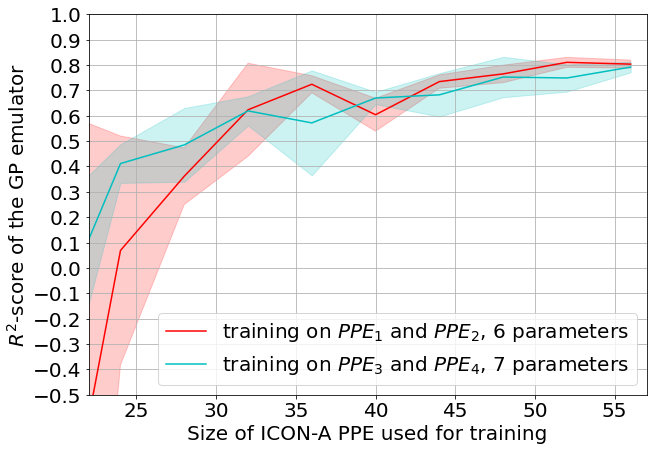

In [16]:
labelPhy=["training on $PPE_1$ and $PPE_2$, 6 parameters","training on $PPE_3$ and $PPE_4$, 7 parameters"]
colors=['r','c']
inddRealistic=np.where(abs(score_isize_60_mean_1stt[:])<1e3)[0] #remove runs that had a bug
inddRealistic_More=np.where(abs(score_isize_60_mean_1stt_More[:])<1e3)[0] #remove runs that had a bug

print(inddRealistic)
plt.subplots()
sizefont=20
plt.rc('font', size=sizefont) 
plt.rcParams['figure.figsize'] = [10, 7]

alp=0.2
iplot=0
plt.plot(sizeRes_60_1stt[inddRealistic],score_isize_60_mean_1stt[inddRealistic],'-',color=colors[iplot],label=labelPhy[iplot])
plt.fill_between(sizeRes_60_1stt[inddRealistic],score_isize_60_mean_1stt[inddRealistic]-score_isize_60_std_1stt[inddRealistic],\
                     score_isize_60_mean_1stt[inddRealistic]+score_isize_60_std_1stt[inddRealistic],\
                        color=colors[iplot],alpha=alp)

iplot=1
plt.plot(sizeRes_60_1stt_More[inddRealistic_More],score_isize_60_mean_1stt_More[inddRealistic_More],'-',color=colors[iplot],label=labelPhy[iplot])
plt.fill_between(sizeRes_60_1stt[inddRealistic_More],score_isize_60_mean_1stt_More[inddRealistic_More]-\
                     score_isize_60_std_1stt_More[inddRealistic_More],score_isize_60_mean_1stt_More[inddRealistic_More]+\
                        score_isize_60_std_1stt_More[inddRealistic_More],color=colors[iplot],alpha=alp)

plt.xlim(22,57)
plt.ylim(-0.5,1)
plt.legend(loc='lower right')
plt.ylabel(r'$R^2$-score of the GP emulator')
plt.xlabel('Size of ICON-A PPE used for training')
plt.yticks(np.arange(-0.5,1.1,0.1))
plt.grid()
#plt.savefig("PaperFig/Performance_Emulator_wrt_size_ICON_PPE_1st_tuning_Step.png")

In [17]:
# train the GP on the training sample - only phy parameters
def score_2nd_tuning_step(varr,resultss):
            
    randsamples={}

    kernel = 1 * Matern(length_scale=1.0)#, nu=1.5) #RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) #np.array([1.0,1.0,1.0])) #length_scale=10) # ,1.0,1.0,1.0]))#, length_scale_bounds=(1e-2, 1e2))
    gaussian_process_multi = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=100)#,alpha=1e-5, n_restarts_optimizer=20)

    #scale data https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
    scaler_var1_2tun = preprocessing.StandardScaler().fit(varr,)
    scaled_var1_2tun = scaler_var1_2tun.transform(varr)

    Ntot=79 # total size of the sample
    sizeRes_80=np.arange(20,78,20) #[10,15,20,25,30,35,40,45,50,55]
    Nrand=5 # number of times we pick a sample of a given size
    score_isize_80=np.zeros((np.size(sizeRes_80),Nrand))
    score_isize_80_max=np.zeros((np.size(sizeRes_80)))
    score_isize_80_min=np.zeros((np.size(sizeRes_80)))
    score_isize_80_mean=np.zeros((np.size(sizeRes_80)))
    score_isize_80_std=np.zeros((np.size(sizeRes_80)))

    indSi=0
    for Sizz in sizeRes_80:
        indsam={}
        for irand in np.arange(0,Nrand):
            RandSamp=random.sample(range(1,Ntot),Sizz)
            indsam[irand]=RandSamp
            scaled_var1_2tun = scaler_var1_2tun.transform(varr[RandSamp])
            gaussian_process_multi.fit(scaled_var1_2tun, resultss[RandSamp]) #results_dyn_2tun_psltauuNAOSSO #results_all_2tun) #
            gaussian_process_multi.kernel_

            score=cross_val_score(gaussian_process_multi, scaled_var1_2tun, resultss[RandSamp])
            score_isize_80[indSi,irand]=np.mean(score)
            
            randsamples[Sizz]=indsam
            score_isize_80_min[indSi]=np.min(score_isize_80[indSi,:])
            score_isize_80_max[indSi]=np.max(score_isize_80[indSi,:])
            score_isize_80_mean[indSi]=np.mean(score_isize_80[indSi,:])
            score_isize_80_std[indSi]=np.std(score_isize_80[indSi,:])

        indSi+=1
    return sizeRes_80,score_isize_80_mean,score_isize_80_std,Nrand
#duration approx 1min10 (5min33sec)

In [18]:
varr=np.concatenate((varPhyDyn_NewParam_2tun,varPhyDyn_NewParam_5thPPE_2tun),axis=0)
resultss=np.concatenate((resultsPhyDyn_NewParam_2tun,results_5thPPE_2tun),axis=0) #phy
sizeRes_80_PhyDyn,score_isize_80_mean_PhyDyn,score_isize_80_std_PhyDyn,Nrand_PhyDyn=score_2nd_tuning_step(varr,resultss)
#approx 2min30sec

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/

In [19]:
#hyperparameter tuning

# 1. effect of the size of the ensemble
## all dynamic outputs
# new hyperparameter tuning steps: take 80% for training, 20% for test
# do first for the size of the ensemble from size 10 to size 48 and sample of size 12 for testing

varr=np.concatenate((var1stPPE,var2ndPPE),axis=0)
ress=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy

# train the GP on the training sample
'''simu1=[0.5,1e-15,100] #nu, alpha, nrestart
simu2=[0.5,1e-10,100] #nu, alpha, nrestart
simu3=[1.5,1e-10,100] #nu, alpha, nrestart
simu4=[1.5,1e-10,0] #nu, alpha, nrestart
'''
#simu1=[1.5,1e-5,50] #nu, alpha, nrestart
#simu2=[1.5,1e-10,50] #nu, alpha, nrestart
#simu3=[0.5,1e-5,50] #nu, alpha, nrestart
#simu4=[0.5,1e-5,100] #nu, alpha, nrestart
simu0=[1.5,1e-10,0] #nu, alpha, nrestart
simu1=[1.5,1e-10,20] #nu, alpha, nrestart
simu2=[0.5,1e-10,20] #nu, alpha, nrestart
simu3=[0.5,1e-5,20] #nu, alpha, nrestart
simu4=[0.5,1e-12,20] #nu, alpha, nrestart
simu5=[0.5,1e-10,50] #nu, alpha, nrestart
#simu4=[0.5,1e-12,100] #nu, alpha, nrestar

simuhyperparam=[simu0,simu1,simu2,simu3,simu4,simu5]
Nsimu=len(simuhyperparam)


Nrand=20 # number of times we pick a sample of a given size
#for irand in np.arange(0,Nrand): repeat 5 times
totind=range(0,len(varr))
sizetest=8
sizetottrain=len(varr)-sizetest
minsizetrain=62
print(sizetottrain)
sizeRes_2nd_allOut=[20,30,40,50] #np.arange(minsizetrain,sizetottrain,1)

score_isize_2nd_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu,Nrand))
score_isize_2nd_mean_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))
score_isize_2nd_std_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))

isimu=0
for simuu in simuhyperparam:
    nuu=simuu[0]
    alphaa=simuu[1]
    n_ress=simuu[2]
    for irand in range(Nrand):
        indtest=random.sample(totind,sizetest) #test set to remove from beginning
        scaler_var = preprocessing.StandardScaler().fit(varr)#[indtest])
        scaled_test = scaler_var.transform(varr[indtest]) 

        notindtest=[x for x in totind if x not in indtest] #all indices except the test indices
        indsam={}
        indSi=0
        for Sizz in sizeRes_2nd_allOut:
            print(Sizz)
            indtrain=random.sample(notindtest,Sizz) #train indices
            indsam[irand]=indtrain
            
            #scaler_var = preprocessing.StandardScaler().fit(varr[indtrain])
            scaled_train= scaler_var.transform(varr[indtrain])
            print('coucou',', irand ',irand,', isimu ', isimu, ', iSizz',Sizz)#,scaled_train) #indSi,indtrain,varr[indtrain],ress[indtrain])
            #scores=gaussian_process_multi.score( scaled_test, ress[indtest]) #scaled_train, ress[indtrain])#
            kernel = 1 * Matern(length_scale=1.0, nu=nuu) 

            gaussian_process_multi = GaussianProcessRegressor(kernel=kernel,alpha=alphaa, n_restarts_optimizer=n_ress)
            resstrain=ress[indtrain]
            resstest=ress[indtest]
            gaussian_process_multi.fit(scaled_train, resstrain) #
            gaussian_process_multi.kernel_

            scores=gaussian_process_multi.score(scaled_test, resstest) #
            print('aft fit', np.mean(scores))
            print(gaussian_process_multi.kernel_)
            
            score_isize_2nd_allOut[indSi,isimu,irand]=np.mean(scores)
            #randsamples_1st[Sizz]=indsam
            indSi+=1
    indSi=0
    for Sizz in sizeRes_2nd_allOut:    
        score_isize_2nd_mean_allOut[indSi,isimu]=np.mean(score_isize_2nd_allOut[indSi,isimu,:])
        score_isize_2nd_std_allOut[indSi,isimu]=np.std(score_isize_2nd_allOut[indSi,isimu,:])
        indSi+=1
    isimu+=1
#duration approx 2min

51
20
coucou , irand  0 , isimu  0 , iSizz 20
aft fit 0.614864723813738
96.6**2 * Matern(length_scale=59.3, nu=1.5)
30
coucou , irand  0 , isimu  0 , iSizz 30
aft fit 0.7168067701032779
95.9**2 * Matern(length_scale=52.5, nu=1.5)
40
coucou , irand  0 , isimu  0 , iSizz 40
aft fit 0.8468096425292785
99.6**2 * Matern(length_scale=51.3, nu=1.5)
50
coucou , irand  0 , isimu  0 , iSizz 50
aft fit 0.8503754437429816
99.4**2 * Matern(length_scale=51.7, nu=1.5)
20
coucou , irand  1 , isimu  0 , iSizz 20
aft fit 0.7791931699902597
94.7**2 * Matern(length_scale=49.7, nu=1.5)
30
coucou , irand  1 , isimu  0 , iSizz 30
aft fit 0.8177305903491277
96.2**2 * Matern(length_scale=53.5, nu=1.5)
40
coucou , irand  1 , isimu  0 , iSizz 40
aft fit 0.9417892878456614
99.4**2 * Matern(length_scale=50.1, nu=1.5)
50
coucou , irand  1 , isimu  0 , iSizz 50
aft fit 0.9426346613839798
102**2 * Matern(length_scale=51.6, nu=1.5)
20
coucou , irand  2 , isimu  0 , iSizz 20
aft fit 0.9164250564364232
97.2**2 * Matern(

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7134514380584498
96**2 * Matern(length_scale=57.6, nu=1.5)
40
coucou , irand  14 , isimu  0 , iSizz 40
aft fit 0.675785589638004
98.9**2 * Matern(length_scale=53.5, nu=1.5)
50
coucou , irand  14 , isimu  0 , iSizz 50
aft fit 0.7054767100649919
101**2 * Matern(length_scale=54.1, nu=1.5)
20
coucou , irand  15 , isimu  0 , iSizz 20
aft fit 0.33151958986149277
100**2 * Matern(length_scale=69.6, nu=1.5)
30
coucou , irand  15 , isimu  0 , iSizz 30
aft fit 0.22512471445672028
99.3**2 * Matern(length_scale=56.4, nu=1.5)
40
coucou , irand  15 , isimu  0 , iSizz 40
aft fit 0.2705676536876479
97.3**2 * Matern(length_scale=53.4, nu=1.5)
50
coucou , irand  15 , isimu  0 , iSizz 50
aft fit 0.3908391853987627
101**2 * Matern(length_scale=54, nu=1.5)
20
coucou , irand  16 , isimu  0 , iSizz 20
aft fit 0.806362188580567
105**2 * Matern(length_scale=72.5, nu=1.5)
30
coucou , irand  16 , isimu  0 , iSizz 30
aft fit 0.7459968383831701
98.6**2 * Matern(length_scale=51.8, nu=1.5)
40
coucou , irand

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7644717424313595
101**2 * Matern(length_scale=58.3, nu=1.5)
50
coucou , irand  0 , isimu  1 , iSizz 50
aft fit 0.8097304042191237
99.3**2 * Matern(length_scale=53.8, nu=1.5)
20
coucou , irand  1 , isimu  1 , iSizz 20
aft fit 0.29821328140694925
101**2 * Matern(length_scale=54.6, nu=1.5)
30
coucou , irand  1 , isimu  1 , iSizz 30
aft fit 0.4876551728004257
99.2**2 * Matern(length_scale=55.5, nu=1.5)
40
coucou , irand  1 , isimu  1 , iSizz 40
aft fit 0.47329223828561384
99.1**2 * Matern(length_scale=53.8, nu=1.5)
50
coucou , irand  1 , isimu  1 , iSizz 50
aft fit 0.550252764588288
100**2 * Matern(length_scale=53.2, nu=1.5)
20
coucou , irand  2 , isimu  1 , iSizz 20
aft fit 0.5722886827298577
92.9**2 * Matern(length_scale=52.3, nu=1.5)
30
coucou , irand  2 , isimu  1 , iSizz 30
aft fit 0.866876847357154
97.3**2 * Matern(length_scale=49.9, nu=1.5)
40
coucou , irand  2 , isimu  1 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7872380771323294
97.1**2 * Matern(length_scale=52.7, nu=1.5)
50
coucou , irand  2 , isimu  1 , iSizz 50
aft fit 0.8739461067566625
102**2 * Matern(length_scale=52.8, nu=1.5)
20
coucou , irand  3 , isimu  1 , iSizz 20
aft fit 0.5962590999494991
92.5**2 * Matern(length_scale=52.1, nu=1.5)
30
coucou , irand  3 , isimu  1 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7614113163754996
97.4**2 * Matern(length_scale=52.2, nu=1.5)
40
coucou , irand  3 , isimu  1 , iSizz 40
aft fit 0.7255210838123245
104**2 * Matern(length_scale=52.8, nu=1.5)
50
coucou , irand  3 , isimu  1 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7892436991341528
101**2 * Matern(length_scale=52.5, nu=1.5)
20
coucou , irand  4 , isimu  1 , iSizz 20
aft fit 0.5744193136976394
98**2 * Matern(length_scale=53.3, nu=1.5)
30
coucou , irand  4 , isimu  1 , iSizz 30
aft fit 0.7556608572738599
97.4**2 * Matern(length_scale=57, nu=1.5)
40
coucou , irand  4 , isimu  1 , iSizz 40
aft fit 0.8651915222214426
100**2 * Matern(length_scale=53.4, nu=1.5)
50
coucou , irand  4 , isimu  1 , iSizz 50
aft fit 0.9217564175134292
101**2 * Matern(length_scale=50.5, nu=1.5)
20
coucou , irand  5 , isimu  1 , iSizz 20
aft fit -1.2477244512557202
97.5**2 * Matern(length_scale=63.1, nu=1.5)
30
coucou , irand  5 , isimu  1 , iSizz 30
aft fit 0.7299130870495029
99.8**2 * Matern(length_scale=52, nu=1.5)
40
coucou , irand  5 , isimu  1 , iSizz 40
aft fit 0.7788781634866673
100**2 * Matern(length_scale=51.4, nu=1.5)
50
coucou , irand  5 , isimu  1 , iSizz 50
aft fit 0.7873677675200306
102**2 * Matern(length_scale=56.3, nu=1.5)
20
coucou , irand  6 , isim

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9602948674023946
101**2 * Matern(length_scale=51.7, nu=1.5)
20
coucou , irand  8 , isimu  1 , iSizz 20
aft fit 0.5683627443004935
96.5**2 * Matern(length_scale=73.7, nu=1.5)
30
coucou , irand  8 , isimu  1 , iSizz 30
aft fit 0.8765006546396326
101**2 * Matern(length_scale=53.9, nu=1.5)
40
coucou , irand  8 , isimu  1 , iSizz 40
aft fit 0.9351439725030396
99.8**2 * Matern(length_scale=53.1, nu=1.5)
50
coucou , irand  8 , isimu  1 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9465450454267179
101**2 * Matern(length_scale=51.3, nu=1.5)
20
coucou , irand  9 , isimu  1 , iSizz 20
aft fit 0.6333181020288781
97.8**2 * Matern(length_scale=67.1, nu=1.5)
30
coucou , irand  9 , isimu  1 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7220518566661152
99.5**2 * Matern(length_scale=49.6, nu=1.5)
40
coucou , irand  9 , isimu  1 , iSizz 40
aft fit 0.6159621462727115
100**2 * Matern(length_scale=55.8, nu=1.5)
50
coucou , irand  9 , isimu  1 , iSizz 50
aft fit 0.5808425626571623
102**2 * Matern(length_scale=55.3, nu=1.5)
20
coucou , irand  10 , isimu  1 , iSizz 20
aft fit -0.21176343581476947
93.8**2 * Matern(length_scale=52.5, nu=1.5)
30
coucou , irand  10 , isimu  1 , iSizz 30
aft fit 0.6090736578755916
102**2 * Matern(length_scale=59.1, nu=1.5)
40
coucou , irand  10 , isimu  1 , iSizz 40
aft fit 0.7085429098940512
100**2 * Matern(length_scale=54, nu=1.5)
50
coucou , irand  10 , isimu  1 , iSizz 50
aft fit 0.7192023303069232
100**2 * Matern(length_scale=54.3, nu=1.5)
20
coucou , irand  11 , isimu  1 , iSizz 20
aft fit 0.5856652320284904
96.1**2 * Matern(length_scale=62, nu=1.5)
30
coucou , irand  11 , isimu  1 , iSizz 30
aft fit 0.7042018871601625
97**2 * Matern(length_scale=54.4, nu=1.5)
40
coucou , irand  1

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9063243365060558
100**2 * Matern(length_scale=52.6, nu=1.5)
20
coucou , irand  13 , isimu  1 , iSizz 20
aft fit 0.4149608966116041
92.8**2 * Matern(length_scale=55.3, nu=1.5)
30
coucou , irand  13 , isimu  1 , iSizz 30
aft fit 0.7821657191783637
95.1**2 * Matern(length_scale=58.3, nu=1.5)
40
coucou , irand  13 , isimu  1 , iSizz 40
aft fit 0.7912408772398752
101**2 * Matern(length_scale=54.8, nu=1.5)
50
coucou , irand  13 , isimu  1 , iSizz 50
aft fit 0.8108565234421865
101**2 * Matern(length_scale=51.9, nu=1.5)
20
coucou , irand  14 , isimu  1 , iSizz 20
aft fit 0.4876711587847112
96.7**2 * Matern(length_scale=57.7, nu=1.5)
30
coucou , irand  14 , isimu  1 , iSizz 30
aft fit 0.5179990940202694
98.2**2 * Matern(length_scale=49.9, nu=1.5)
40
coucou , irand  14 , isimu  1 , iSizz 40
aft fit 0.8267694311818492
99.2**2 * Matern(length_scale=52.3, nu=1.5)
50
coucou , irand  14 , isimu  1 , iSizz 50
aft fit 0.7888436833960221
99.5**2 * Matern(length_scale=50.3, nu=1.5)
20
coucou , 

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9529572017674625
101**2 * Matern(length_scale=54.2, nu=1.5)
20
coucou , irand  16 , isimu  1 , iSizz 20
aft fit 0.587717785651137
102**2 * Matern(length_scale=63.1, nu=1.5)
30
coucou , irand  16 , isimu  1 , iSizz 30
aft fit 0.898864482266956
96**2 * Matern(length_scale=51, nu=1.5)
40
coucou , irand  16 , isimu  1 , iSizz 40
aft fit 0.8658720269436377
100**2 * Matern(length_scale=53.6, nu=1.5)
50
coucou , irand  16 , isimu  1 , iSizz 50
aft fit 0.931996594868882
100**2 * Matern(length_scale=53.2, nu=1.5)
20
coucou , irand  17 , isimu  1 , iSizz 20
aft fit 0.007035529358274206
105**2 * Matern(length_scale=67.8, nu=1.5)
30
coucou , irand  17 , isimu  1 , iSizz 30
aft fit 0.31277774665691765
97.6**2 * Matern(length_scale=57.3, nu=1.5)
40
coucou , irand  17 , isimu  1 , iSizz 40
aft fit 0.6584371323523672
102**2 * Matern(length_scale=55.5, nu=1.5)
50
coucou , irand  17 , isimu  1 , iSizz 50
aft fit 0.6997798770432657
102**2 * Matern(length_scale=54.9, nu=1.5)
20
coucou , irand  1

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7104151150608482
101**2 * Matern(length_scale=56.3, nu=1.5)
50
coucou , irand  19 , isimu  1 , iSizz 50
aft fit 0.707699017534426
100**2 * Matern(length_scale=53.1, nu=1.5)
20
coucou , irand  0 , isimu  2 , iSizz 20
aft fit 0.5815822663234727
156**2 * Matern(length_scale=2.36e+04, nu=0.5)
30
coucou , irand  0 , isimu  2 , iSizz 30
aft fit 0.6722129691347258
156**2 * Matern(length_scale=2.85e+04, nu=0.5)
40
coucou , irand  0 , isimu  2 , iSizz 40
aft fit 0.6807945895884883
156**2 * Matern(length_scale=3.02e+04, nu=0.5)
50
coucou , irand  0 , isimu  2 , iSizz 50
aft fit 0.7552676250450785
156**2 * Matern(length_scale=3.44e+04, nu=0.5)
20
coucou , irand  1 , isimu  2 , iSizz 20
aft fit 0.6329859096551019
155**2 * Matern(length_scale=2.43e+04, nu=0.5)
30
coucou , irand  1 , isimu  2 , iSizz 30
aft fit 0.8574499296295246
155**2 * Matern(length_scale=3.47e+04, nu=0.5)
40
coucou , irand  1 , isimu  2 , iSizz 40
aft fit 0.7705585946236738
156**2 * Matern(length_scale=2.95e+04, nu=0.5

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8242615044650847
156**2 * Matern(length_scale=3.39e+04, nu=0.5)
20
coucou , irand  2 , isimu  2 , iSizz 20
aft fit 0.7937543927585232
155**2 * Matern(length_scale=2.65e+04, nu=0.5)
30
coucou , irand  2 , isimu  2 , iSizz 30
aft fit 0.8223621492462255
156**2 * Matern(length_scale=2.56e+04, nu=0.5)
40
coucou , irand  2 , isimu  2 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7995078442427769
156**2 * Matern(length_scale=3.32e+04, nu=0.5)
50
coucou , irand  2 , isimu  2 , iSizz 50
aft fit 0.8423636194473417
156**2 * Matern(length_scale=3.35e+04, nu=0.5)
20
coucou , irand  3 , isimu  2 , iSizz 20
aft fit 0.3565024683113822
156**2 * Matern(length_scale=2.44e+04, nu=0.5)
30
coucou , irand  3 , isimu  2 , iSizz 30
aft fit 0.578211404855075
156**2 * Matern(length_scale=2.74e+04, nu=0.5)
40
coucou , irand  3 , isimu  2 , iSizz 40
aft fit 0.7771407566201317
156**2 * Matern(length_scale=3.27e+04, nu=0.5)
50
coucou , irand  3 , isimu  2 , iSizz 50
aft fit 0.7499588944370388
156**2 * Matern(length_scale=3.44e+04, nu=0.5)
20
coucou , irand  4 , isimu  2 , iSizz 20
aft fit 0.8189618495772795
155**2 * Matern(length_scale=3.04e+04, nu=0.5)
30
coucou , irand  4 , isimu  2 , iSizz 30
aft fit 0.9403956207748415
156**2 * Matern(length_scale=2.71e+04, nu=0.5)
40
coucou , irand  4 , isimu  2 , iSizz 40
aft fit 0.8969320003070699
156**2 * Matern(length_scale=3.17e+04,

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6727847855524458
155**2 * Matern(length_scale=3.69e+04, nu=0.5)
50
coucou , irand  10 , isimu  2 , iSizz 50
aft fit 0.7158193138463188
156**2 * Matern(length_scale=4.23e+04, nu=0.5)
20
coucou , irand  11 , isimu  2 , iSizz 20
aft fit 0.8575912058339998
156**2 * Matern(length_scale=2.79e+04, nu=0.5)
30
coucou , irand  11 , isimu  2 , iSizz 30
aft fit 0.8663526871202437
156**2 * Matern(length_scale=2.58e+04, nu=0.5)
40
coucou , irand  11 , isimu  2 , iSizz 40
aft fit 0.9227810896159407
156**2 * Matern(length_scale=3.39e+04, nu=0.5)
50
coucou , irand  11 , isimu  2 , iSizz 50
aft fit 0.9117484830182052
156**2 * Matern(length_scale=3.32e+04, nu=0.5)
20
coucou , irand  12 , isimu  2 , iSizz 20
aft fit 0.6124257485251583
155**2 * Matern(length_scale=2.43e+04, nu=0.5)
30
coucou , irand  12 , isimu  2 , iSizz 30
aft fit 0.7050325382192566
155**2 * Matern(length_scale=4.26e+04, nu=0.5)
40
coucou , irand  12 , isimu  2 , iSizz 40
aft fit 0.7888043165275331
156**2 * Matern(length_scale=

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6441528265042129
156**2 * Matern(length_scale=3.61e+04, nu=0.5)
50
coucou , irand  7 , isimu  3 , iSizz 50
aft fit 0.70666629924511
156**2 * Matern(length_scale=3.38e+04, nu=0.5)
20
coucou , irand  8 , isimu  3 , iSizz 20
aft fit 0.7954826749830446
156**2 * Matern(length_scale=2.69e+04, nu=0.5)
30
coucou , irand  8 , isimu  3 , iSizz 30
aft fit 0.8457336690017249
156**2 * Matern(length_scale=2.65e+04, nu=0.5)
40
coucou , irand  8 , isimu  3 , iSizz 40
aft fit 0.9345021615605102
156**2 * Matern(length_scale=2.78e+04, nu=0.5)
50
coucou , irand  8 , isimu  3 , iSizz 50
aft fit 0.9109956376392292
156**2 * Matern(length_scale=3.3e+04, nu=0.5)
20
coucou , irand  9 , isimu  3 , iSizz 20
aft fit 0.7535995284245384
155**2 * Matern(length_scale=3.84e+04, nu=0.5)
30
coucou , irand  9 , isimu  3 , iSizz 30
aft fit 0.7977708335943015
155**2 * Matern(length_scale=3.17e+04, nu=0.5)
40
coucou , irand  9 , isimu  3 , iSizz 40
aft fit 0.818401345082318
156**2 * Matern(length_scale=3.76e+04, nu

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8250267578321907
156**2 * Matern(length_scale=3.43e+04, nu=0.5)
40
coucou , irand  11 , isimu  3 , iSizz 40
aft fit 0.8252649031021461
156**2 * Matern(length_scale=2.94e+04, nu=0.5)
50
coucou , irand  11 , isimu  3 , iSizz 50
aft fit 0.8800153759702347
156**2 * Matern(length_scale=3.39e+04, nu=0.5)
20
coucou , irand  12 , isimu  3 , iSizz 20
aft fit 0.7541031679981942
156**2 * Matern(length_scale=3.13e+04, nu=0.5)
30
coucou , irand  12 , isimu  3 , iSizz 30
aft fit 0.8432067747090534
156**2 * Matern(length_scale=2.59e+04, nu=0.5)
40
coucou , irand  12 , isimu  3 , iSizz 40
aft fit 0.9058421039425365
156**2 * Matern(length_scale=2.9e+04, nu=0.5)
50
coucou , irand  12 , isimu  3 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9100842264553851
156**2 * Matern(length_scale=3.44e+04, nu=0.5)
20
coucou , irand  13 , isimu  3 , iSizz 20
aft fit 0.4409928600981713
156**2 * Matern(length_scale=2.21e+04, nu=0.5)
30
coucou , irand  13 , isimu  3 , iSizz 30
aft fit 0.6132399608471811
155**2 * Matern(length_scale=2.84e+04, nu=0.5)
40
coucou , irand  13 , isimu  3 , iSizz 40
aft fit 0.5156121043681858
156**2 * Matern(length_scale=4.46e+04, nu=0.5)
50
coucou , irand  13 , isimu  3 , iSizz 50
aft fit 0.6878480633162676
156**2 * Matern(length_scale=3.59e+04, nu=0.5)
20
coucou , irand  14 , isimu  3 , iSizz 20
aft fit 0.6696940594530771
155**2 * Matern(length_scale=2.66e+04, nu=0.5)
30
coucou , irand  14 , isimu  3 , iSizz 30
aft fit 0.6314300703020128
155**2 * Matern(length_scale=3.67e+04, nu=0.5)
40
coucou , irand  14 , isimu  3 , iSizz 40
aft fit 0.6354107911518281
155**2 * Matern(length_scale=3.89e+04, nu=0.5)
50
coucou , irand  14 , isimu  3 , iSizz 50
aft fit 0.6991243860225387
156**2 * Matern(length_scale=

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8297170397418636
155**2 * Matern(length_scale=3.43e+04, nu=0.5)
40
coucou , irand  5 , isimu  4 , iSizz 40
aft fit 0.7626506693261594
156**2 * Matern(length_scale=3.26e+04, nu=0.5)
50
coucou , irand  5 , isimu  4 , iSizz 50
aft fit 0.7928634879815097
156**2 * Matern(length_scale=3.78e+04, nu=0.5)
20
coucou , irand  6 , isimu  4 , iSizz 20
aft fit 0.5829483026129049
155**2 * Matern(length_scale=2.29e+04, nu=0.5)
30
coucou , irand  6 , isimu  4 , iSizz 30
aft fit 0.7227657766788657
156**2 * Matern(length_scale=3.59e+04, nu=0.5)
40
coucou , irand  6 , isimu  4 , iSizz 40
aft fit 0.8390625038222919
156**2 * Matern(length_scale=3.2e+04, nu=0.5)
50
coucou , irand  6 , isimu  4 , iSizz 50
aft fit 0.8702293963556516
156**2 * Matern(length_scale=3.38e+04, nu=0.5)
20
coucou , irand  7 , isimu  4 , iSizz 20
aft fit 0.6532873497835903
155**2 * Matern(length_scale=3.07e+04, nu=0.5)
30
coucou , irand  7 , isimu  4 , iSizz 30
aft fit 0.6876448938525437
156**2 * Matern(length_scale=2.65e+04,

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9316349116015067
156**2 * Matern(length_scale=3.23e+04, nu=0.5)
20
coucou , irand  1 , isimu  5 , iSizz 20
aft fit 0.7171072976020046
156**2 * Matern(length_scale=2.64e+04, nu=0.5)
30
coucou , irand  1 , isimu  5 , iSizz 30
aft fit 0.7202238453343481
156**2 * Matern(length_scale=3.76e+04, nu=0.5)
40
coucou , irand  1 , isimu  5 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7998775106681807
156**2 * Matern(length_scale=3.24e+04, nu=0.5)
50
coucou , irand  1 , isimu  5 , iSizz 50
aft fit 0.8143060484917338
156**2 * Matern(length_scale=3.68e+04, nu=0.5)
20
coucou , irand  2 , isimu  5 , iSizz 20
aft fit 0.5027147127971922
155**2 * Matern(length_scale=2.78e+04, nu=0.5)
30
coucou , irand  2 , isimu  5 , iSizz 30
aft fit 0.45289574020301265
156**2 * Matern(length_scale=3.69e+04, nu=0.5)
40
coucou , irand  2 , isimu  5 , iSizz 40
aft fit 0.6474535905556619
156**2 * Matern(length_scale=3.05e+04, nu=0.5)
50
coucou , irand  2 , isimu  5 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6391044883136721
156**2 * Matern(length_scale=3.7e+04, nu=0.5)
20
coucou , irand  3 , isimu  5 , iSizz 20
aft fit 0.4643338359465895
155**2 * Matern(length_scale=3.38e+04, nu=0.5)
30
coucou , irand  3 , isimu  5 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8434963563275304
156**2 * Matern(length_scale=2.8e+04, nu=0.5)
40
coucou , irand  3 , isimu  5 , iSizz 40
aft fit 0.8271632930240699
156**2 * Matern(length_scale=3.1e+04, nu=0.5)
50
coucou , irand  3 , isimu  5 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8864392877587225
156**2 * Matern(length_scale=3.29e+04, nu=0.5)
20
coucou , irand  4 , isimu  5 , iSizz 20
aft fit 0.41253187373506367
154**2 * Matern(length_scale=3.35e+04, nu=0.5)
30
coucou , irand  4 , isimu  5 , iSizz 30
aft fit 0.8233517010217982
156**2 * Matern(length_scale=3.01e+04, nu=0.5)
40
coucou , irand  4 , isimu  5 , iSizz 40
aft fit 0.8933724515568171
156**2 * Matern(length_scale=2.97e+04, nu=0.5)
50
coucou , irand  4 , isimu  5 , iSizz 50
aft fit 0.918710620390485
156**2 * Matern(length_scale=3.4e+04, nu=0.5)
20
coucou , irand  5 , isimu  5 , iSizz 20
aft fit 0.030461057533825907
155**2 * Matern(length_scale=3.42e+04, nu=0.5)
30
coucou , irand  5 , isimu  5 , iSizz 30
aft fit 0.6198808606004894
155**2 * Matern(length_scale=2.83e+04, nu=0.5)
40
coucou , irand  5 , isimu  5 , iSizz 40
aft fit 0.7529766944237055
156**2 * Matern(length_scale=2.9e+04, nu=0.5)
50
coucou , irand  5 , isimu  5 , iSizz 50
aft fit 0.8210284415816768
156**2 * Matern(length_scale=3.4e+04,

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6269739964076761
155**2 * Matern(length_scale=3.63e+04, nu=0.5)
30
coucou , irand  8 , isimu  5 , iSizz 30
aft fit 0.7667305061862545
155**2 * Matern(length_scale=4.36e+04, nu=0.5)
40
coucou , irand  8 , isimu  5 , iSizz 40
aft fit 0.7712078400860124
156**2 * Matern(length_scale=3.23e+04, nu=0.5)
50
coucou , irand  8 , isimu  5 , iSizz 50
aft fit 0.7860554275812353
156**2 * Matern(length_scale=3.76e+04, nu=0.5)
20
coucou , irand  9 , isimu  5 , iSizz 20
aft fit 0.5244437386863705
155**2 * Matern(length_scale=2.96e+04, nu=0.5)
30
coucou , irand  9 , isimu  5 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6924759801132232
155**2 * Matern(length_scale=3.67e+04, nu=0.5)
40
coucou , irand  9 , isimu  5 , iSizz 40
aft fit 0.7298700423148198
155**2 * Matern(length_scale=4.03e+04, nu=0.5)
50
coucou , irand  9 , isimu  5 , iSizz 50
aft fit 0.7804243402403787
156**2 * Matern(length_scale=3.63e+04, nu=0.5)
20
coucou , irand  10 , isimu  5 , iSizz 20
aft fit 0.5669937964212407
156**2 * Matern(length_scale=2.52e+04, nu=0.5)
30
coucou , irand  10 , isimu  5 , iSizz 30
aft fit 0.7540848799069768
156**2 * Matern(length_scale=3.29e+04, nu=0.5)
40
coucou , irand  10 , isimu  5 , iSizz 40
aft fit 0.8071491760083047
157**2 * Matern(length_scale=3.04e+04, nu=0.5)
50
coucou , irand  10 , isimu  5 , iSizz 50
aft fit 0.8302159092569426
156**2 * Matern(length_scale=3.51e+04, nu=0.5)
20
coucou , irand  11 , isimu  5 , iSizz 20
aft fit 0.5565392665118043
155**2 * Matern(length_scale=2.83e+04, nu=0.5)
30
coucou , irand  11 , isimu  5 , iSizz 30
aft fit 0.8600994299843926
156**2 * Matern(length_scale=2.

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9365717594226632
156**2 * Matern(length_scale=3.27e+04, nu=0.5)
20
coucou , irand  19 , isimu  5 , iSizz 20
aft fit 0.8404225010679663
156**2 * Matern(length_scale=2.42e+04, nu=0.5)
30
coucou , irand  19 , isimu  5 , iSizz 30
aft fit 0.789980515167591
155**2 * Matern(length_scale=3.4e+04, nu=0.5)
40
coucou , irand  19 , isimu  5 , iSizz 40
aft fit 0.915800579480635
156**2 * Matern(length_scale=3.05e+04, nu=0.5)
50
coucou , irand  19 , isimu  5 , iSizz 50
aft fit 0.9328098152478367
156**2 * Matern(length_scale=3.38e+04, nu=0.5)


In [20]:
#hyperparameter tuning : effect of nu
varr=np.concatenate((var1stPPE,var2ndPPE),axis=0)
ress=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy

# train the GP on the training sample
inu=[0.5,1.5,3] #nu, alpha, nrestart
Nsimu=len(inu)
Nrand=20 # number of times we pick a sample of a given size
#for irand in np.arange(0,Nrand): repeat 5 times
totind=range(0,len(varr))
sizetest=8
sizetottrain=len(varr)-sizetest
minsizetrain=62
print(sizetottrain)
sizeRes_2nd_allOut=[20,30,40,50] #np.arange(minsizetrain,sizetottrain,1)

score_isize_2nd_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu,Nrand))
score_nu_mean=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))
score_nu_std=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))

isimu=0
for nuu in inu:
    for irand in range(Nrand):
        indtest=random.sample(totind,sizetest) #test set to remove from beginning
        scaler_var = preprocessing.StandardScaler().fit(varr)#[indtest])
        scaled_test = scaler_var.transform(varr[indtest]) 

        notindtest=[x for x in totind if x not in indtest] #all indices except the test indices
        indsam={}
        indSi=0
        for Sizz in sizeRes_2nd_allOut:
            print(Sizz)
            indtrain=random.sample(notindtest,Sizz) #train indices
            indsam[irand]=indtrain
            
            #scaler_var = preprocessing.StandardScaler().fit(varr[indtrain])
            scaled_train= scaler_var.transform(varr[indtrain])
            print('coucou',', irand ',irand,', isimu ', isimu, ', nu',nuu)#,scaled_train) #indSi,indtrain,varr[indtrain],ress[indtrain])
            #scores=gaussian_process_multi.score( scaled_test, ress[indtest]) #scaled_train, ress[indtrain])#
            if nuu==3:
                kernel = 1 * RBF(length_scale=1.0) 
            else:
                kernel = 1 * Matern(length_scale=1.0, nu=nuu) 

            gaussian_process_multi = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5) #)#,alpha=alphaa,
            resstrain=ress[indtrain]
            resstest=ress[indtest]
            gaussian_process_multi.fit(scaled_train, resstrain) #
            gaussian_process_multi.kernel_

            scores=gaussian_process_multi.score(scaled_test, resstest) #
            print('aft fit', np.mean(scores))
            print(gaussian_process_multi.kernel_)
            
            score_isize_2nd_allOut[indSi,isimu,irand]=np.mean(scores)
            #randsamples_1st[Sizz]=indsam
            indSi+=1
    indSi=0
    for Sizz in sizeRes_2nd_allOut:    
        score_nu_mean[indSi,isimu]=np.mean(score_isize_2nd_allOut[indSi,isimu,:])
        score_nu_std[indSi,isimu]=np.std(score_isize_2nd_allOut[indSi,isimu,:])
        indSi+=1
    isimu+=1
#duration approx 20sec

51
20
coucou , irand  0 , isimu  0 , nu 0.5
aft fit 0.31441192299902465
155**2 * Matern(length_scale=3.63e+04, nu=0.5)
30
coucou , irand  0 , isimu  0 , nu 0.5
aft fit 0.384736150479157
156**2 * Matern(length_scale=2.71e+04, nu=0.5)
40
coucou , irand  0 , isimu  0 , nu 0.5


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.63611655359292
156**2 * Matern(length_scale=3.1e+04, nu=0.5)
50
coucou , irand  0 , isimu  0 , nu 0.5
aft fit 0.7298487385825839
156**2 * Matern(length_scale=3.48e+04, nu=0.5)
20
coucou , irand  1 , isimu  0 , nu 0.5
aft fit 0.808340963924076
155**2 * Matern(length_scale=2.68e+04, nu=0.5)
30
coucou , irand  1 , isimu  0 , nu 0.5
aft fit 0.779926058630523
155**2 * Matern(length_scale=3.85e+04, nu=0.5)
40
coucou , irand  1 , isimu  0 , nu 0.5
aft fit 0.7911964593452459
156**2 * Matern(length_scale=3.08e+04, nu=0.5)
50
coucou , irand  1 , isimu  0 , nu 0.5
aft fit 0.8727803947423409
156**2 * Matern(length_scale=3.38e+04, nu=0.5)
20
coucou , irand  2 , isimu  0 , nu 0.5
aft fit 0.7666513757114528
155**2 * Matern(length_scale=3.09e+04, nu=0.5)
30
coucou , irand  2 , isimu  0 , nu 0.5
aft fit 0.6534324158375016
156**2 * Matern(length_scale=2.59e+04, nu=0.5)
40
coucou , irand  2 , isimu  0 , nu 0.5
aft fit 0.7367103829307553
156**2 * Matern(length_scale=3e+04, nu=0.5)
50
coucou , ir

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8504620547196409
156**2 * Matern(length_scale=4.09e+04, nu=0.5)
20
coucou , irand  16 , isimu  0 , nu 0.5
aft fit 0.7578442962953243
156**2 * Matern(length_scale=1.81e+04, nu=0.5)
30
coucou , irand  16 , isimu  0 , nu 0.5
aft fit 0.7558191082885758
156**2 * Matern(length_scale=2.44e+04, nu=0.5)
40
coucou , irand  16 , isimu  0 , nu 0.5
aft fit 0.840556246134162
156**2 * Matern(length_scale=3.16e+04, nu=0.5)
50
coucou , irand  16 , isimu  0 , nu 0.5
aft fit 0.8114392750066004
156**2 * Matern(length_scale=3.56e+04, nu=0.5)
20
coucou , irand  17 , isimu  0 , nu 0.5
aft fit 0.7641710896045022
156**2 * Matern(length_scale=2.5e+04, nu=0.5)
30
coucou , irand  17 , isimu  0 , nu 0.5
aft fit 0.8209216122993201
155**2 * Matern(length_scale=3.77e+04, nu=0.5)
40
coucou , irand  17 , isimu  0 , nu 0.5
aft fit 0.8554707090662174
156**2 * Matern(length_scale=3.3e+04, nu=0.5)
50
coucou , irand  17 , isimu  0 , nu 0.5
aft fit 0.842039803961162
156**2 * Matern(length_scale=3.51e+04, nu=0.5)
20

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7597827155600234
155**2 * Matern(length_scale=2.99e+04, nu=0.5)
30
coucou , irand  19 , isimu  0 , nu 0.5
aft fit 0.8853206535953941
156**2 * Matern(length_scale=2.8e+04, nu=0.5)
40
coucou , irand  19 , isimu  0 , nu 0.5
aft fit 0.8996616145495601
156**2 * Matern(length_scale=2.95e+04, nu=0.5)
50
coucou , irand  19 , isimu  0 , nu 0.5
aft fit 0.9129943012014514
156**2 * Matern(length_scale=3.3e+04, nu=0.5)
20
coucou , irand  0 , isimu  1 , nu 1.5
aft fit 0.3804961524931152
101**2 * Matern(length_scale=69.9, nu=1.5)
30
coucou , irand  0 , isimu  1 , nu 1.5
aft fit 0.698082747965934
99.9**2 * Matern(length_scale=57.4, nu=1.5)
40
coucou , irand  0 , isimu  1 , nu 1.5


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.3776853612794088
103**2 * Matern(length_scale=54.8, nu=1.5)
50
coucou , irand  0 , isimu  1 , nu 1.5
aft fit 0.6399322381854441
101**2 * Matern(length_scale=53.5, nu=1.5)
20
coucou , irand  1 , isimu  1 , nu 1.5
aft fit 0.7156647182373701
102**2 * Matern(length_scale=63.1, nu=1.5)
30
coucou , irand  1 , isimu  1 , nu 1.5
aft fit 0.7941705653556574
102**2 * Matern(length_scale=61.3, nu=1.5)
40
coucou , irand  1 , isimu  1 , nu 1.5
aft fit 0.8464424871940499
99.1**2 * Matern(length_scale=55.3, nu=1.5)
50
coucou , irand  1 , isimu  1 , nu 1.5
aft fit 0.8126772550958664
99.6**2 * Matern(length_scale=55.1, nu=1.5)
20
coucou , irand  2 , isimu  1 , nu 1.5
aft fit 0.556881021810801
102**2 * Matern(length_scale=76.6, nu=1.5)
30
coucou , irand  2 , isimu  1 , nu 1.5
aft fit 0.7628182801933804
98.8**2 * Matern(length_scale=55.6, nu=1.5)
40
coucou , irand  2 , isimu  1 , nu 1.5
aft fit 0.4111177045596571
100**2 * Matern(length_scale=56.1, nu=1.5)
50
coucou , irand  2 , isimu  1 , nu 1.5

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

aft fit -119830.13293619838
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  1 , isimu  2 , nu 3
aft fit -3.0413876969779934
135**2 * RBF(length_scale=15.1)
30
coucou , irand  1 , isimu  2 , nu 3
aft fit -6.81069926263625
110**2 * RBF(length_scale=9.06)
40
coucou , irand  1 , isimu  2 , nu 3
aft fit -80138.78288990239
155**2 * RBF(length_scale=1.88e-05)
50
coucou , irand  1 , isimu  2 , nu 3
aft fit -80138.78288990239
155**2 * RBF(length_scale=0.00434)
20
coucou , irand  2 , isimu  2 , nu 3
aft fit 0.2805464930382654
140**2 * RBF(length_scale=16.4)
30
coucou , irand  2 , isimu  2 , nu 3
aft fit -0.012379275396714818
101**2 * RBF(length_scale=8.33)
40
coucou , irand  2 , isimu  2 , nu 3
aft fit -20080.487468662548
155**2 * RBF(length_scale=0.000163)
50
coucou , irand  2 , isimu  2 , nu 3
aft fit -20080.487468662548
155**2 * RBF(length_scale=1.86e-05)
20
coucou , irand  3 , isimu  2 , nu 3
aft fit -0.7647756329474048
129**2 * RBF(length_scale=15.3)
30
coucou , irand  3 , isimu  2 , nu

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -21533.9721713346
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  4 , isimu  2 , nu 3
aft fit -21533.9721713346
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  5 , isimu  2 , nu 3
aft fit 0.5793961086428523
159**2 * RBF(length_scale=17.9)
30
coucou , irand  5 , isimu  2 , nu 3
aft fit -15926.34890026375
154**2 * RBF(length_scale=1e-05)
40
coucou , irand  5 , isimu  2 , nu 3
aft fit -15926.34890026375
155**2 * RBF(length_scale=0.00119)
50
coucou , irand  5 , isimu  2 , nu 3
aft fit -15926.34890026375
155**2 * RBF(length_scale=0.000119)
20
coucou , irand  6 , isimu  2 , nu 3
aft fit -3.791670573058687
139**2 * RBF(length_scale=13.9)
30
coucou , irand  6 , isimu  2 , nu 3
aft fit -0.24466327905420965
106**2 * RBF(length_scale=11)
40
coucou , irand  6 , isimu  2 , nu 3
aft fit -53977.644441455755
155**2 * RBF(length_scale=0.0299)
50
coucou , irand  6 , isimu  2 , nu 3
aft fit -53977.644441455755
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  7 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -0.03647138587336356
129**2 * RBF(length_scale=19.2)
30
coucou , irand  7 , isimu  2 , nu 3
aft fit -0.9170450588154788
123**2 * RBF(length_scale=13.8)
40
coucou , irand  7 , isimu  2 , nu 3
aft fit -18837.349125416335
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  7 , isimu  2 , nu 3
aft fit -18837.349125416335
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  8 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -1.1872563911021423
154**2 * RBF(length_scale=16.6)
30
coucou , irand  8 , isimu  2 , nu 3
aft fit -0.632096652053758
121**2 * RBF(length_scale=10.2)
40
coucou , irand  8 , isimu  2 , nu 3
aft fit -82940.95066046351
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  8 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -82940.95066046351
155**2 * RBF(length_scale=8.56e-05)
20
coucou , irand  9 , isimu  2 , nu 3
aft fit 0.5484616682247638
136**2 * RBF(length_scale=23.3)
30
coucou , irand  9 , isimu  2 , nu 3
aft fit -9.41024665109818
122**2 * RBF(length_scale=14.6)
40
coucou , irand  9 , isimu  2 , nu 3
aft fit -46176.24065521911
155**2 * RBF(length_scale=1.92e-05)
50
coucou , irand  9 , isimu  2 , nu 3
aft fit -46176.22239592705
155**2 * RBF(length_scale=0.0383)
20
coucou , irand  10 , isimu  2 , nu 3
aft fit -0.9835084168085191
110**2 * RBF(length_scale=14.7)
30
coucou , irand  10 , isimu  2 , nu 3
aft fit 0.2165792533089718
128**2 * RBF(length_scale=13.1)
40
coucou , irand  10 , isimu  2 , nu 3
aft fit -21893.070280982392
155**2 * RBF(length_scale=0.0336)
50
coucou , irand  10 , isimu  2 , nu 3
aft fit -21893.07028832577
155**2 * RBF(length_scale=0.0283)
20
coucou , irand  11 , isimu  2 , nu 3
aft fit 0.46250473749739224
147**2 * RBF(length_scale=16.9)
30
coucou , irand  11 , isimu  2 , nu 

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit 0.5820633467094041
98.2**2 * RBF(length_scale=8.25)
50
coucou , irand  11 , isimu  2 , nu 3
aft fit -15373.385026651493
155**2 * RBF(length_scale=0.0155)
20
coucou , irand  12 , isimu  2 , nu 3
aft fit -1.7875257539750813
159**2 * RBF(length_scale=15.8)
30
coucou , irand  12 , isimu  2 , nu 3
aft fit -4.094218716224793
110**2 * RBF(length_scale=8.96)
40
coucou , irand  12 , isimu  2 , nu 3
aft fit -13790.641226076605
155**2 * RBF(length_scale=0.00176)
50
coucou , irand  12 , isimu  2 , nu 3
aft fit -13790.641226076605
155**2 * RBF(length_scale=0.0394)
20
coucou , irand  13 , isimu  2 , nu 3
aft fit -5.007119757029907
131**2 * RBF(length_scale=17.5)
30
coucou , irand  13 , isimu  2 , nu 3
aft fit -0.24409400316822688
111**2 * RBF(length_scale=9.89)
40
coucou , irand  13 , isimu  2 , nu 3
aft fit -8.164687808196444
97.1**2 * RBF(length_scale=7.55)
50
coucou , irand  13 , isimu  2 , nu 3
aft fit -65922.43633665
155**2 * RBF(length_scale=0.000335)
20
coucou , irand  14 , isimu  2 ,

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -36861.66060320853
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  14 , isimu  2 , nu 3
aft fit -0.3646238157766831
94.6**2 * RBF(length_scale=6.61)
20
coucou , irand  15 , isimu  2 , nu 3
aft fit -1.8002480253394135
157**2 * RBF(length_scale=17.1)
30
coucou , irand  15 , isimu  2 , nu 3
aft fit -6.948249929321054
118**2 * RBF(length_scale=11)
40
coucou , irand  15 , isimu  2 , nu 3
aft fit -13791.090264394792
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  15 , isimu  2 , nu 3
aft fit -13791.090264394792
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  16 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -1.390632986707378
149**2 * RBF(length_scale=16.9)
30
coucou , irand  16 , isimu  2 , nu 3
aft fit -3.227300786824314
114**2 * RBF(length_scale=10.2)
40
coucou , irand  16 , isimu  2 , nu 3
aft fit -53335.371083663274
155**2 * RBF(length_scale=6.28e-05)
50
coucou , irand  16 , isimu  2 , nu 3
aft fit -53335.371083663274
155**2 * RBF(length_scale=0.00409)
20
coucou , irand  17 , isimu  2 , nu 3
aft fit 0.899015057503173
132**2 * RBF(length_scale=19.9)
30
coucou , irand  17 , isimu  2 , nu 3
aft fit 0.056683175452072375
111**2 * RBF(length_scale=10.7)
40
coucou , irand  17 , isimu  2 , nu 3
aft fit -20881.751267311036
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  17 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -20881.751267311036
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  18 , isimu  2 , nu 3
aft fit -0.30980074789811207
144**2 * RBF(length_scale=17.1)
30
coucou , irand  18 , isimu  2 , nu 3
aft fit 0.37971642391611404
94.9**2 * RBF(length_scale=9.4)
40
coucou , irand  18 , isimu  2 , nu 3
aft fit -15040.82569480455
155**2 * RBF(length_scale=4.59e-05)
50
coucou , irand  18 , isimu  2 , nu 3
aft fit -15040.82569480455
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  19 , isimu  2 , nu 3
aft fit 0.9093611685042202
137**2 * RBF(length_scale=18)
30
coucou , irand  19 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -20170.965694308536
155**2 * RBF(length_scale=0.1)
40
coucou , irand  19 , isimu  2 , nu 3
aft fit 0.5255239720805968
101**2 * RBF(length_scale=8.56)
50
coucou , irand  19 , isimu  2 , nu 3
aft fit -20173.507280355156
155**2 * RBF(length_scale=0.018)


0
1
2
3


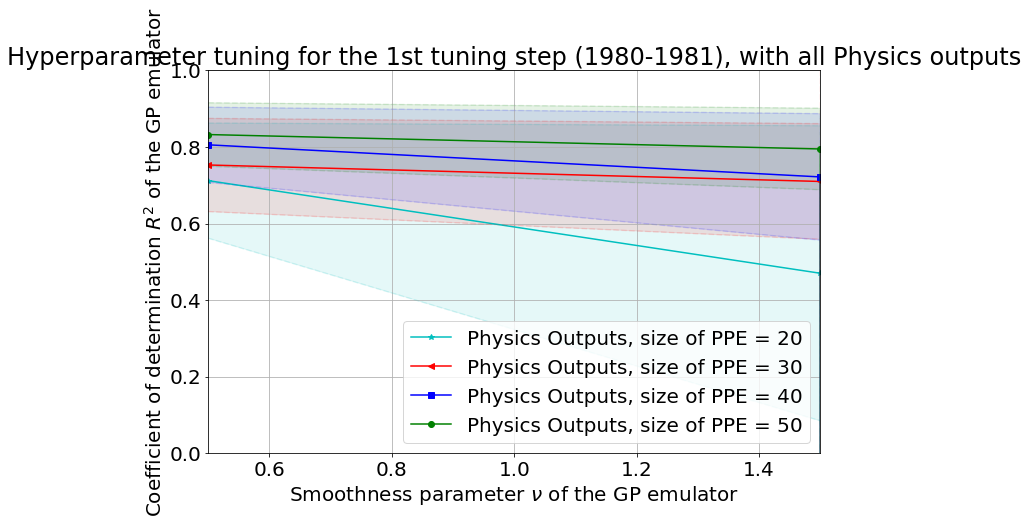

In [21]:
#figures 
labelPhyDyn=["Physics Outputs,", "Dynamics Outputs,"]

colors=['c','r','b','g','purple','orange']
linestyle=['-*','-<','-s','-o','-^','->']
#inddRealistic=np.where(abs(score_isize_2nd_mean[:,0,0])<1e10)[0] #remove runs that had a bug 
#print(inddRealistic)

plt.rcParams['figure.figsize'] = [10, 7]
plt.subplots()
ioutput=0
icol=0

for isimu in np.arange(len(sizeRes_2nd_allOut)):
    print(isimu)
    #for isimu in np.arange(np.len(score_nu_mean)-3,np.len(score_nu_mean)):
    plt.plot(inu,score_nu_mean[isimu,:],linestyle[isimu],\
                color=colors[isimu],label=labelPhyDyn[ioutput]+' size of PPE = '+str(sizeRes_2nd_allOut[isimu]))
                #', alpha = '+str(simuhyperparam[isimu][1])+', n_restart = '+str(simuhyperparam[isimu][2]))
    plt.plot(inu,score_nu_mean[isimu,:]+score_nu_std[isimu,:],'--',\
                color=colors[isimu],alpha=0.1)
    plt.plot(inu,score_nu_mean[isimu,:]-score_nu_std[isimu,:],'--',\
                color=colors[isimu],alpha=0.1)
    plt.fill_between(inu[:],score_nu_mean[isimu,:]-score_nu_std[isimu,:],score_nu_mean[isimu,:]+score_nu_std[isimu,:],\
                            color=colors[isimu],alpha=0.1)


plt.xlim(0.5,1.5,3)
#plt.xticks([0.5,1.5,3],labels=["0.5","1.5","inf"])
plt.ylim(0,1)
#plt.yticks(np.arange(0,1,0.1))
plt.title('Hyperparameter tuning for the 1st tuning step (1980-1981), with all Physics outputs')
plt.legend(loc='lower right')
plt.ylabel(r'Coefficient of determination $R^2$ of the GP emulator')
plt.xlabel(r'Smoothness parameter $\nu$ of the GP emulator')
plt.grid()
plt.tight_layout()
#plt.savefig("PaperFig/Performance_Emulator_wrt_Hyperparameters_1sttuningStep_nu.png")

In [22]:
#hyperparameter tuning : effect of alpha
varr=np.concatenate((var1stPPE,var2ndPPE),axis=0)
ress=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy

# train the GP on the training sample
ialp=[1e-5,1e-6,1e-7,1e-8,1e-9,1e-10] #nu, alpha, nrestart
Nsimu=len(ialp)
Nrand=20 # number of times we pick a sample of a given size
#for irand in np.arange(0,Nrand): repeat 5 times
totind=range(0,len(varr))
sizetest=8
sizetottrain=len(varr)-sizetest
minsizetrain=62
print(sizetottrain)
sizeRes_2nd_allOut=[20,30,40,50] #np.arange(minsizetrain,sizetottrain,1)

score_isize_2nd_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu,Nrand))
score_alp_mean=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))
score_alp_std=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))

isimu=0
for alp in ialp:
    for irand in range(Nrand):
        indtest=random.sample(totind,sizetest) #test set to remove from beginning
        scaler_var = preprocessing.StandardScaler().fit(varr)#[indtest])
        scaled_test = scaler_var.transform(varr[indtest]) 

        notindtest=[x for x in totind if x not in indtest] #all indices except the test indices
        indsam={}
        indSi=0
        for Sizz in sizeRes_2nd_allOut:
            print(Sizz)
            indtrain=random.sample(notindtest,Sizz) #train indices
            indsam[irand]=indtrain
            
            #scaler_var = preprocessing.StandardScaler().fit(varr[indtrain])
            scaled_train= scaler_var.transform(varr[indtrain])
            print('coucou',', irand ',irand,', isimu ', isimu, ', iSizz',Sizz)#,scaled_train) #indSi,indtrain,varr[indtrain],ress[indtrain])
            #scores=gaussian_process_multi.score( scaled_test, ress[indtest]) #scaled_train, ress[indtrain])#
            kernel = 1 * Matern(length_scale=1.0)#, nu=nuu) 

            gaussian_process_multi = GaussianProcessRegressor(kernel=kernel,alpha=alp)#, n_restarts_optimizer=n_ress)
            resstrain=ress[indtrain]
            resstest=ress[indtest]
            gaussian_process_multi.fit(scaled_train, resstrain) #
            gaussian_process_multi.kernel_

            scores=gaussian_process_multi.score(scaled_test, resstest) #
            print('aft fit', np.mean(scores))
            print(gaussian_process_multi.kernel_)
            
            score_isize_2nd_allOut[indSi,isimu,irand]=np.mean(scores)
            #randsamples_1st[Sizz]=indsam
            indSi+=1
    indSi=0
    for Sizz in sizeRes_2nd_allOut:    
        score_alp_mean[indSi,isimu]=np.mean(score_isize_2nd_allOut[indSi,isimu,:])
        score_alp_std[indSi,isimu]=np.std(score_isize_2nd_allOut[indSi,isimu,:])
        indSi+=1
    isimu+=1
#duration approx 20sec

51
20
coucou , irand  0 , isimu  0 , iSizz 20
aft fit 0.8006150224900477
98.6**2 * Matern(length_scale=70.3, nu=1.5)
30
coucou , irand  0 , isimu  0 , iSizz 30
aft fit 0.7718656292939172
98.4**2 * Matern(length_scale=50.9, nu=1.5)
40
coucou , irand  0 , isimu  0 , iSizz 40
aft fit 0.718947641708785
101**2 * Matern(length_scale=52.6, nu=1.5)
50
coucou , irand  0 , isimu  0 , iSizz 50
aft fit 0.7820810044971968
103**2 * Matern(length_scale=53.2, nu=1.5)
20
coucou , irand  1 , isimu  0 , iSizz 20
aft fit 0.3058175000812562
98.6**2 * Matern(length_scale=61.7, nu=1.5)
30
coucou , irand  1 , isimu  0 , iSizz 30
aft fit 0.3480990821625939
106**2 * Matern(length_scale=58.4, nu=1.5)
40
coucou , irand  1 , isimu  0 , iSizz 40
aft fit 0.8150444263555414
98.7**2 * Matern(length_scale=52.4, nu=1.5)
50
coucou , irand  1 , isimu  0 , iSizz 50
aft fit 0.7203190219303579
101**2 * Matern(length_scale=52.8, nu=1.5)
20
coucou , irand  2 , isimu  0 , iSizz 20
aft fit 0.7183309278853957
96.8**2 * Matern(len

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.3877849630513891
102**2 * Matern(length_scale=52.7, nu=1.5)
50
coucou , irand  4 , isimu  2 , iSizz 50
aft fit 0.6858688934554568
102**2 * Matern(length_scale=53, nu=1.5)
20
coucou , irand  5 , isimu  2 , iSizz 20
aft fit 0.7990112458643414
99.3**2 * Matern(length_scale=64.1, nu=1.5)
30
coucou , irand  5 , isimu  2 , iSizz 30
aft fit 0.8005533499385968
101**2 * Matern(length_scale=53.3, nu=1.5)
40
coucou , irand  5 , isimu  2 , iSizz 40
aft fit 0.8718345905084532
98.9**2 * Matern(length_scale=51.4, nu=1.5)
50
coucou , irand  5 , isimu  2 , iSizz 50
aft fit 0.8415424646629234
101**2 * Matern(length_scale=54.2, nu=1.5)
20
coucou , irand  6 , isimu  2 , iSizz 20
aft fit 0.653178769844556
98.4**2 * Matern(length_scale=66.8, nu=1.5)
30
coucou , irand  6 , isimu  2 , iSizz 30
aft fit 0.5912188636665219
99.9**2 * Matern(length_scale=63.3, nu=1.5)
40
coucou , irand  6 , isimu  2 , iSizz 40
aft fit 0.8645366762437998
100**2 * Matern(length_scale=54.1, nu=1.5)
50
coucou , irand  6 , is

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.5084254748416377
93.6**2 * Matern(length_scale=58.8, nu=1.5)
30
coucou , irand  12 , isimu  3 , iSizz 30
aft fit 0.7708439130791531
100**2 * Matern(length_scale=56.5, nu=1.5)
40
coucou , irand  12 , isimu  3 , iSizz 40
aft fit 0.8646736533248698
100**2 * Matern(length_scale=54.5, nu=1.5)
50
coucou , irand  12 , isimu  3 , iSizz 50
aft fit 0.8644247198271051
101**2 * Matern(length_scale=54.3, nu=1.5)
20
coucou , irand  13 , isimu  3 , iSizz 20
aft fit 0.5931863766450323
95.1**2 * Matern(length_scale=46.4, nu=1.5)
30
coucou , irand  13 , isimu  3 , iSizz 30
aft fit 0.8533643085950283
100**2 * Matern(length_scale=55.5, nu=1.5)
40
coucou , irand  13 , isimu  3 , iSizz 40
aft fit 0.8954338612802355
96.3**2 * Matern(length_scale=53.4, nu=1.5)
50
coucou , irand  13 , isimu  3 , iSizz 50
aft fit 0.786897661456994
102**2 * Matern(length_scale=51, nu=1.5)
20
coucou , irand  14 , isimu  3 , iSizz 20
aft fit 0.6373821676390976
96.9**2 * Matern(length_scale=58.1, nu=1.5)
30
coucou , irand

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9497544224226045
102**2 * Matern(length_scale=50.6, nu=1.5)
20
coucou , irand  19 , isimu  3 , iSizz 20
aft fit 0.7084515597332673
94.4**2 * Matern(length_scale=60.4, nu=1.5)
30
coucou , irand  19 , isimu  3 , iSizz 30
aft fit 0.7352424430899752
95.6**2 * Matern(length_scale=53.2, nu=1.5)
40
coucou , irand  19 , isimu  3 , iSizz 40
aft fit 0.9109186434142252
102**2 * Matern(length_scale=55.4, nu=1.5)
50
coucou , irand  19 , isimu  3 , iSizz 50
aft fit 0.9436323276745323
101**2 * Matern(length_scale=52.5, nu=1.5)
20
coucou , irand  0 , isimu  4 , iSizz 20
aft fit 0.7879884831922435
97.9**2 * Matern(length_scale=47.4, nu=1.5)
30
coucou , irand  0 , isimu  4 , iSizz 30
aft fit 0.8462173210139472
97.9**2 * Matern(length_scale=52.4, nu=1.5)
40
coucou , irand  0 , isimu  4 , iSizz 40
aft fit 0.8671889029900377
101**2 * Matern(length_scale=54.8, nu=1.5)
50
coucou , irand  0 , isimu  4 , iSizz 50
aft fit 0.9111697893398475
101**2 * Matern(length_scale=51.4, nu=1.5)
20
coucou , irand 

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.5897100647200203
100**2 * Matern(length_scale=56.3, nu=1.5)
20
coucou , irand  16 , isimu  4 , iSizz 20
aft fit 0.7708038064920388
99.2**2 * Matern(length_scale=48.4, nu=1.5)
30
coucou , irand  16 , isimu  4 , iSizz 30
aft fit 0.7393210722964778
102**2 * Matern(length_scale=56.3, nu=1.5)
40
coucou , irand  16 , isimu  4 , iSizz 40
aft fit 0.7917949837360777
99.7**2 * Matern(length_scale=50.8, nu=1.5)
50
coucou , irand  16 , isimu  4 , iSizz 50
aft fit 0.8056071276388359
101**2 * Matern(length_scale=54.2, nu=1.5)
20
coucou , irand  17 , isimu  4 , iSizz 20
aft fit -2.920660683641119
96.2**2 * Matern(length_scale=58.4, nu=1.5)
30
coucou , irand  17 , isimu  4 , iSizz 30
aft fit -0.9656362644605186
106**2 * Matern(length_scale=65, nu=1.5)
40
coucou , irand  17 , isimu  4 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit -0.8226754948643933
99.8**2 * Matern(length_scale=52.9, nu=1.5)
50
coucou , irand  17 , isimu  4 , iSizz 50
aft fit 0.2094617752145706
101**2 * Matern(length_scale=52.1, nu=1.5)
20
coucou , irand  18 , isimu  4 , iSizz 20
aft fit 0.8526793970908383
99.7**2 * Matern(length_scale=67.9, nu=1.5)
30
coucou , irand  18 , isimu  4 , iSizz 30
aft fit 0.8580477456903882
99.3**2 * Matern(length_scale=50.5, nu=1.5)
40
coucou , irand  18 , isimu  4 , iSizz 40
aft fit 0.944400023474589
102**2 * Matern(length_scale=55.2, nu=1.5)
50
coucou , irand  18 , isimu  4 , iSizz 50
aft fit 0.9276902199047846
101**2 * Matern(length_scale=55.7, nu=1.5)
20
coucou , irand  19 , isimu  4 , iSizz 20
aft fit 0.7922301632506802
96.3**2 * Matern(length_scale=51, nu=1.5)
30
coucou , irand  19 , isimu  4 , iSizz 30
aft fit 0.8525588019629892
97.7**2 * Matern(length_scale=50.9, nu=1.5)
40
coucou , irand  19 , isimu  4 , iSizz 40
aft fit 0.8539720063842399
100**2 * Matern(length_scale=55.3, nu=1.5)
50
coucou , ira

In [23]:
#hyperparameter tuning : effect of nrestart
varr=np.concatenate((var1stPPE,var2ndPPE),axis=0)
ress=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy

# train the GP on the training sample
inre=[0,1,5,10,20,50,100] #nu, alpha, nrestart
Nsimu=len(inre)
Nrand=10 # number of times we pick a sample of a given size
#for irand in np.arange(0,Nrand): repeat 5 times
totind=range(0,len(varr))
sizetest=8
sizetottrain=len(varr)-sizetest
minsizetrain=62
print(sizetottrain)
sizeRes_2nd_allOut=[20,30,40,50] #np.arange(minsizetrain,sizetottrain,1)

score_isize_2nd_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu,Nrand))
score_nre_mean=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))
score_nre_std=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))

isimu=0
for nre in inre:
    for irand in range(Nrand):
        indtest=random.sample(totind,sizetest) #test set to remove from beginning
        scaler_var = preprocessing.StandardScaler().fit(varr)#[indtest])
        scaled_test = scaler_var.transform(varr[indtest]) 

        notindtest=[x for x in totind if x not in indtest] #all indices except the test indices
        indsam={}
        indSi=0
        for Sizz in sizeRes_2nd_allOut:
            print(Sizz)
            indtrain=random.sample(notindtest,Sizz) #train indices
            indsam[irand]=indtrain
            
            #scaler_var = preprocessing.StandardScaler().fit(varr[indtrain])
            scaled_train= scaler_var.transform(varr[indtrain])
            print('coucou',', irand ',irand,', isimu ', isimu, ', iSizz',Sizz)#,scaled_train) #indSi,indtrain,varr[indtrain],ress[indtrain])
            #scores=gaussian_process_multi.score( scaled_test, ress[indtest]) #scaled_train, ress[indtrain])#
            kernel = 1 * Matern(length_scale=1.0)#, nu=nuu) 

            gaussian_process_multi = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=nre)
            resstrain=ress[indtrain]
            resstest=ress[indtest]
            gaussian_process_multi.fit(scaled_train, resstrain) #
            gaussian_process_multi.kernel_

            scores=gaussian_process_multi.score(scaled_test, resstest) #
            print('aft fit', np.mean(scores))
            print(gaussian_process_multi.kernel_)
            
            score_isize_2nd_allOut[indSi,isimu,irand]=np.mean(scores)
            #randsamples_1st[Sizz]=indsam
            indSi+=1
    indSi=0
    for Sizz in sizeRes_2nd_allOut:    
        score_nre_mean[indSi,isimu]=np.mean(score_isize_2nd_allOut[indSi,isimu,:])
        score_nre_std[indSi,isimu]=np.std(score_isize_2nd_allOut[indSi,isimu,:])
        indSi+=1
    isimu+=1
#duration approx 2min

51
20
coucou , irand  0 , isimu  0 , iSizz 20
aft fit -0.35631008104003703
98.6**2 * Matern(length_scale=58.2, nu=1.5)
30
coucou , irand  0 , isimu  0 , iSizz 30
aft fit 0.35799506710375295
97.1**2 * Matern(length_scale=53.9, nu=1.5)
40
coucou , irand  0 , isimu  0 , iSizz 40
aft fit 0.5076831086293024
102**2 * Matern(length_scale=54.4, nu=1.5)
50
coucou , irand  0 , isimu  0 , iSizz 50
aft fit 0.6765770575807661
100**2 * Matern(length_scale=54.1, nu=1.5)
20
coucou , irand  1 , isimu  0 , iSizz 20
aft fit 0.527407774542675
96.7**2 * Matern(length_scale=56.5, nu=1.5)
30
coucou , irand  1 , isimu  0 , iSizz 30
aft fit 0.7734237743289757
99**2 * Matern(length_scale=52.4, nu=1.5)
40
coucou , irand  1 , isimu  0 , iSizz 40
aft fit 0.8595375610301701
98.7**2 * Matern(length_scale=51.6, nu=1.5)
50
coucou , irand  1 , isimu  0 , iSizz 50
aft fit 0.8130178601982191
100**2 * Matern(length_scale=51.9, nu=1.5)
20
coucou , irand  2 , isimu  0 , iSizz 20
aft fit 0.7730581610772619
97.5**2 * Matern(l

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.4782784548690053
94.5**2 * Matern(length_scale=59.4, nu=1.5)
30
coucou , irand  0 , isimu  3 , iSizz 30
aft fit 0.5731180150736159
93.2**2 * Matern(length_scale=53.1, nu=1.5)
40
coucou , irand  0 , isimu  3 , iSizz 40
aft fit 0.7044793038647563
96.3**2 * Matern(length_scale=50.4, nu=1.5)
50
coucou , irand  0 , isimu  3 , iSizz 50
aft fit 0.7454844799400343
98.4**2 * Matern(length_scale=53.3, nu=1.5)
20
coucou , irand  1 , isimu  3 , iSizz 20
aft fit 0.8798543689724021
101**2 * Matern(length_scale=64.8, nu=1.5)
30
coucou , irand  1 , isimu  3 , iSizz 30
aft fit 0.8291653314469704
94.7**2 * Matern(length_scale=52, nu=1.5)
40
coucou , irand  1 , isimu  3 , iSizz 40
aft fit 0.90033953520812
99.8**2 * Matern(length_scale=51.4, nu=1.5)
50
coucou , irand  1 , isimu  3 , iSizz 50
aft fit 0.8996404631157938
102**2 * Matern(length_scale=53.2, nu=1.5)
20
coucou , irand  2 , isimu  3 , iSizz 20
aft fit 0.43978003005305916
101**2 * Matern(length_scale=59.8, nu=1.5)
30
coucou , irand  2 , 

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.46374592123637903
104**2 * Matern(length_scale=55.2, nu=1.5)
40
coucou , irand  5 , isimu  4 , iSizz 40
aft fit 0.7846713952236175
98.9**2 * Matern(length_scale=54.3, nu=1.5)
50
coucou , irand  5 , isimu  4 , iSizz 50
aft fit 0.8586939985273586
102**2 * Matern(length_scale=52.8, nu=1.5)
20
coucou , irand  6 , isimu  4 , iSizz 20
aft fit 0.6159104053853748
98.9**2 * Matern(length_scale=50.3, nu=1.5)
30
coucou , irand  6 , isimu  4 , iSizz 30
aft fit 0.5765977099340323
101**2 * Matern(length_scale=56.6, nu=1.5)
40
coucou , irand  6 , isimu  4 , iSizz 40
aft fit 0.9085404142134166
101**2 * Matern(length_scale=51.8, nu=1.5)
50
coucou , irand  6 , isimu  4 , iSizz 50
aft fit 0.9513705975309087
102**2 * Matern(length_scale=52.9, nu=1.5)
20
coucou , irand  7 , isimu  4 , iSizz 20
aft fit 0.6043841898275852
105**2 * Matern(length_scale=70.7, nu=1.5)
30
coucou , irand  7 , isimu  4 , iSizz 30
aft fit 0.8567430779004603
97**2 * Matern(length_scale=57, nu=1.5)
40
coucou , irand  7 , isi

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8552246023116782
97**2 * Matern(length_scale=52.7, nu=1.5)
50
coucou , irand  1 , isimu  5 , iSizz 50
aft fit 0.8410058733103047
100**2 * Matern(length_scale=52.1, nu=1.5)
20
coucou , irand  2 , isimu  5 , iSizz 20
aft fit -0.06057808547654764
99**2 * Matern(length_scale=77.5, nu=1.5)
30
coucou , irand  2 , isimu  5 , iSizz 30
aft fit 0.14902907462999612
95.7**2 * Matern(length_scale=55.2, nu=1.5)
40
coucou , irand  2 , isimu  5 , iSizz 40
aft fit 0.7346248389687611
101**2 * Matern(length_scale=53.6, nu=1.5)
50
coucou , irand  2 , isimu  5 , iSizz 50
aft fit 0.8608914586016855
99.7**2 * Matern(length_scale=51.2, nu=1.5)
20
coucou , irand  3 , isimu  5 , iSizz 20


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7549646509362941
92.9**2 * Matern(length_scale=60, nu=1.5)
30
coucou , irand  3 , isimu  5 , iSizz 30
aft fit 0.9285153642423438
94.5**2 * Matern(length_scale=48.5, nu=1.5)
40
coucou , irand  3 , isimu  5 , iSizz 40
aft fit 0.6558423720522877
97**2 * Matern(length_scale=57.7, nu=1.5)
50
coucou , irand  3 , isimu  5 , iSizz 50
aft fit 0.9498649436395559
101**2 * Matern(length_scale=51.8, nu=1.5)
20
coucou , irand  4 , isimu  5 , iSizz 20


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.3211239570201562
98**2 * Matern(length_scale=49.7, nu=1.5)
30
coucou , irand  4 , isimu  5 , iSizz 30
aft fit 0.8391148901905838
100**2 * Matern(length_scale=52.4, nu=1.5)
40
coucou , irand  4 , isimu  5 , iSizz 40
aft fit 0.8658732750023889
101**2 * Matern(length_scale=51.9, nu=1.5)
50
coucou , irand  4 , isimu  5 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9039379351988426
101**2 * Matern(length_scale=51.5, nu=1.5)
20
coucou , irand  5 , isimu  5 , iSizz 20
aft fit 0.7961212385333902
102**2 * Matern(length_scale=67.4, nu=1.5)
30
coucou , irand  5 , isimu  5 , iSizz 30
aft fit 0.741584088748349
102**2 * Matern(length_scale=53.6, nu=1.5)
40
coucou , irand  5 , isimu  5 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8352476820412686
101**2 * Matern(length_scale=56.4, nu=1.5)
50
coucou , irand  5 , isimu  5 , iSizz 50
aft fit 0.8596716835276096
102**2 * Matern(length_scale=55.2, nu=1.5)
20
coucou , irand  6 , isimu  5 , iSizz 20
aft fit 0.7580069019455123
101**2 * Matern(length_scale=60.9, nu=1.5)
30
coucou , irand  6 , isimu  5 , iSizz 30
aft fit 0.9074347906913145
99.6**2 * Matern(length_scale=55.9, nu=1.5)
40
coucou , irand  6 , isimu  5 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9192478436555153
98.5**2 * Matern(length_scale=49.7, nu=1.5)
50
coucou , irand  6 , isimu  5 , iSizz 50
aft fit 0.932479693263368
100**2 * Matern(length_scale=51.9, nu=1.5)
20
coucou , irand  7 , isimu  5 , iSizz 20
aft fit 0.7382416391301088
95.2**2 * Matern(length_scale=59.7, nu=1.5)
30
coucou , irand  7 , isimu  5 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6218938912068636
97.9**2 * Matern(length_scale=52, nu=1.5)
40
coucou , irand  7 , isimu  5 , iSizz 40
aft fit 0.7450102206277394
96.6**2 * Matern(length_scale=51.4, nu=1.5)
50
coucou , irand  7 , isimu  5 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.737890726184039
97.8**2 * Matern(length_scale=54.2, nu=1.5)
20
coucou , irand  8 , isimu  5 , iSizz 20
aft fit 0.6225869205963396
99.7**2 * Matern(length_scale=57.4, nu=1.5)
30
coucou , irand  8 , isimu  5 , iSizz 30
aft fit 0.6986387569183646
98.9**2 * Matern(length_scale=63.4, nu=1.5)
40
coucou , irand  8 , isimu  5 , iSizz 40
aft fit 0.8577679030538585
97.2**2 * Matern(length_scale=53.3, nu=1.5)
50
coucou , irand  8 , isimu  5 , iSizz 50
aft fit 0.9056321597255771
100**2 * Matern(length_scale=51.6, nu=1.5)
20
coucou , irand  9 , isimu  5 , iSizz 20
aft fit 0.6166781830815908
101**2 * Matern(length_scale=64.6, nu=1.5)
30
coucou , irand  9 , isimu  5 , iSizz 30
aft fit 0.7312363343701975
97.3**2 * Matern(length_scale=50.4, nu=1.5)
40
coucou , irand  9 , isimu  5 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8125344962491032
102**2 * Matern(length_scale=50.9, nu=1.5)
50
coucou , irand  9 , isimu  5 , iSizz 50
aft fit 0.8325128972011159
102**2 * Matern(length_scale=52.4, nu=1.5)
20
coucou , irand  0 , isimu  6 , iSizz 20


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8754623149784381
92.2**2 * Matern(length_scale=51.9, nu=1.5)
30
coucou , irand  0 , isimu  6 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8716041092938873
103**2 * Matern(length_scale=57.5, nu=1.5)
40
coucou , irand  0 , isimu  6 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9288918457711111
99.5**2 * Matern(length_scale=49.7, nu=1.5)
50
coucou , irand  0 , isimu  6 , iSizz 50
aft fit 0.9674078719507305
101**2 * Matern(length_scale=51.4, nu=1.5)
20
coucou , irand  1 , isimu  6 , iSizz 20


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8044196899504288
97.9**2 * Matern(length_scale=47.7, nu=1.5)
30
coucou , irand  1 , isimu  6 , iSizz 30
aft fit 0.8501946623273865
97**2 * Matern(length_scale=52.2, nu=1.5)
40
coucou , irand  1 , isimu  6 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8643495247225657
100**2 * Matern(length_scale=54.8, nu=1.5)
50
coucou , irand  1 , isimu  6 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9228661222597412
101**2 * Matern(length_scale=53.4, nu=1.5)
20
coucou , irand  2 , isimu  6 , iSizz 20
aft fit 0.7328099209774213
104**2 * Matern(length_scale=71.5, nu=1.5)
30
coucou , irand  2 , isimu  6 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7902501662210095
95.5**2 * Matern(length_scale=48.8, nu=1.5)
40
coucou , irand  2 , isimu  6 , iSizz 40
aft fit 0.6728421455688267
102**2 * Matern(length_scale=57.4, nu=1.5)
50
coucou , irand  2 , isimu  6 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7690726460478815
101**2 * Matern(length_scale=53.9, nu=1.5)
20
coucou , irand  3 , isimu  6 , iSizz 20
aft fit 0.3528629346583875
97.2**2 * Matern(length_scale=53.8, nu=1.5)
30
coucou , irand  3 , isimu  6 , iSizz 30
aft fit 0.6911375539098692
99.2**2 * Matern(length_scale=51.4, nu=1.5)
40
coucou , irand  3 , isimu  6 , iSizz 40
aft fit 0.6045017852799616
100**2 * Matern(length_scale=51.9, nu=1.5)
50
coucou , irand  3 , isimu  6 , iSizz 50
aft fit 0.7687079241303952
103**2 * Matern(length_scale=54.9, nu=1.5)
20
coucou , irand  4 , isimu  6 , iSizz 20
aft fit 0.5629635490950864
100**2 * Matern(length_scale=52.2, nu=1.5)
30
coucou , irand  4 , isimu  6 , iSizz 30
aft fit 0.5756743124703979
97**2 * Matern(length_scale=54.3, nu=1.5)
40
coucou , irand  4 , isimu  6 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6975160070860167
100**2 * Matern(length_scale=52.4, nu=1.5)
50
coucou , irand  4 , isimu  6 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6596178181221066
102**2 * Matern(length_scale=50.9, nu=1.5)
20
coucou , irand  5 , isimu  6 , iSizz 20


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.1924015120992763
100**2 * Matern(length_scale=56.4, nu=1.5)
30
coucou , irand  5 , isimu  6 , iSizz 30
aft fit 0.7838619713885265
101**2 * Matern(length_scale=52.6, nu=1.5)
40
coucou , irand  5 , isimu  6 , iSizz 40
aft fit 0.7778904774280747
101**2 * Matern(length_scale=56.3, nu=1.5)
50
coucou , irand  5 , isimu  6 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7695978758746713
102**2 * Matern(length_scale=53.6, nu=1.5)
20
coucou , irand  6 , isimu  6 , iSizz 20
aft fit 0.6607957481129222
98.6**2 * Matern(length_scale=68.5, nu=1.5)
30
coucou , irand  6 , isimu  6 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8506520064147851
100**2 * Matern(length_scale=51.9, nu=1.5)
40
coucou , irand  6 , isimu  6 , iSizz 40
aft fit 0.8149512687608407
99.5**2 * Matern(length_scale=54.3, nu=1.5)
50
coucou , irand  6 , isimu  6 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8212254005505674
101**2 * Matern(length_scale=54.5, nu=1.5)
20
coucou , irand  7 , isimu  6 , iSizz 20
aft fit 0.008885376416129142
99.8**2 * Matern(length_scale=60.6, nu=1.5)
30
coucou , irand  7 , isimu  6 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.88330055120281
95.9**2 * Matern(length_scale=52.4, nu=1.5)
40
coucou , irand  7 , isimu  6 , iSizz 40
aft fit 0.7448339560982651
98.4**2 * Matern(length_scale=55.8, nu=1.5)
50
coucou , irand  7 , isimu  6 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9303452002328797
100**2 * Matern(length_scale=54.2, nu=1.5)
20
coucou , irand  8 , isimu  6 , iSizz 20
aft fit 0.5522288772269792
93.4**2 * Matern(length_scale=52.1, nu=1.5)
30
coucou , irand  8 , isimu  6 , iSizz 30
aft fit 0.6013370670295859
98**2 * Matern(length_scale=56.6, nu=1.5)
40
coucou , irand  8 , isimu  6 , iSizz 40
aft fit 0.6802517246507733
100**2 * Matern(length_scale=56.5, nu=1.5)
50
coucou , irand  8 , isimu  6 , iSizz 50
aft fit 0.5761740458166459
102**2 * Matern(length_scale=54, nu=1.5)
20
coucou , irand  9 , isimu  6 , iSizz 20
aft fit 0.5302250156908871
99.2**2 * Matern(length_scale=66.6, nu=1.5)
30
coucou , irand  9 , isimu  6 , iSizz 30
aft fit 0.7806528057986898
95.2**2 * Matern(length_scale=56.2, nu=1.5)
40
coucou , irand  9 , isimu  6 , iSizz 40
aft fit 0.739676376470392
102**2 * Matern(length_scale=56, nu=1.5)
50
coucou , irand  9 , isimu  6 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.585805576373307
102**2 * Matern(length_scale=53, nu=1.5)


0
1
2
3
0
1
2
3
0
1
2
3


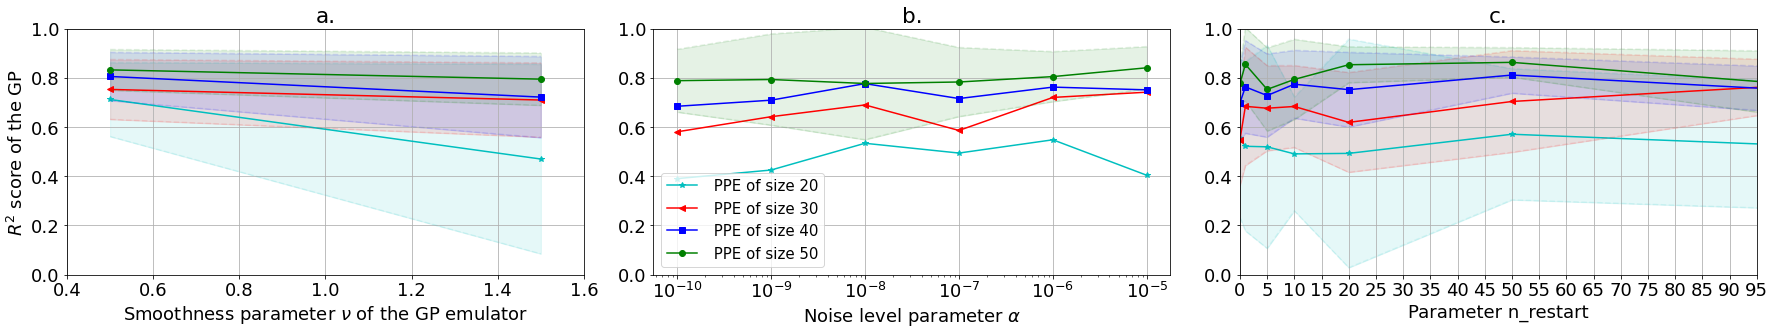

In [24]:
#all hyperparameters in one subplot

#figures 

labelPhyDyn=["Physics Outputs,", "Dynamics Outputs,"]

colors=['c','r','b','g','purple','orange']
linestyle=['-*','-<','-s','-o','-^','->']
#inddRealistic=np.where(abs(score_isize_2nd_mean[:,0,0])<1e10)[0] #remove runs that had a bug 
#print(inddRealistic)

plt.rcParams['figure.figsize'] = [25, 5]
plt.rcParams["legend.fontsize"] = 15
plt.rcParams.update({'font.size': 18})
ioutput=0
icol=0

fig, axs = plt.subplots(3, sharey=True)
plt.subplot(1,3,1)
Nnu=2
for isimu in np.arange(len(sizeRes_2nd_allOut)):
    print(isimu)
    #for isimu in np.arange(np.len(score_nu_mean)-3,np.len(score_nu_mean)):
    plt.plot(inu[:Nnu],score_nu_mean[isimu,:Nnu],linestyle[isimu],\
                color=colors[isimu],label=' PPE of size '+str(sizeRes_2nd_allOut[isimu]))
                #', alpha = '+str(simuhyperparam[isimu][1])+', n_restart = '+str(simuhyperparam[isimu][2]))
    plt.plot(inu[:Nnu],score_nu_mean[isimu,:Nnu]+score_nu_std[isimu,:Nnu],'--',\
                color=colors[isimu],alpha=0.1)
    plt.plot(inu[:Nnu],score_nu_mean[isimu,:Nnu]-score_nu_std[isimu,:Nnu],'--',\
                color=colors[isimu],alpha=0.1)
    plt.fill_between(inu[:Nnu],score_nu_mean[isimu,:Nnu]-score_nu_std[isimu,:Nnu],score_nu_mean[isimu,:Nnu]+score_nu_std[isimu,:Nnu],\
                            color=colors[isimu],alpha=0.1)


plt.xlim(0.4,1.6)
#plt.xticks([0.5,1.5,3],labels=["0.5","1.5","inf"])
plt.ylim(0,1)
#plt.yticks(np.arange(0,1,0.1))
plt.title('a.')
#plt.legend(loc='lower right')
plt.ylabel(r'$R^2$ score of the GP')
plt.xlabel(r'Smoothness parameter $\nu$ of the GP emulator')
plt.grid()
plt.tight_layout()

plt.subplot(1,3,2)
for isimu in np.arange(len(sizeRes_2nd_allOut)):
    print(isimu)
    #for isimu in np.arange(np.len(score_nu_mean)-3,np.len(score_nu_mean)):
    plt.semilogx(ialp,score_alp_mean[isimu,:],linestyle[isimu],\
                color=colors[isimu],label=' PPE of size '+str(sizeRes_2nd_allOut[isimu]))
                #', alpha = '+str(simuhyperparam[isimu][1])+', n_restart = '+str(simuhyperparam[isimu][2]))
plt.semilogx(ialp,score_alp_mean[isimu,:]+score_alp_std[isimu,:],'--',\
                color=colors[isimu],alpha=0.1)
plt.semilogx(ialp,score_alp_mean[isimu,:]-score_alp_std[isimu,:],'--',\
                color=colors[isimu],alpha=0.1)
plt.fill_between(ialp[:],score_alp_mean[isimu,:]-score_alp_std[isimu,:],score_alp_mean[isimu,:]+score_alp_std[isimu,:],\
                            color=colors[isimu],alpha=0.1)


#plt.xlim(-1e-10,1e-5)
plt.ylim(0.,1)
#plt.yticks(np.arange(0,1,0.1))
plt.title('b.')
plt.legend(loc='lower left')
#plt.ylabel(r'Coefficient of determination $R^2$ of the GP emulator')
plt.xlabel(r'Noise level parameter $\alpha$')
plt.grid()
plt.tight_layout()

plt.subplot(1,3,3)
for isimu in np.arange(len(sizeRes_2nd_allOut)):
    print(isimu)
    #for isimu in np.arange(np.len(score_nu_mean)-3,np.len(score_nu_mean)):
    plt.plot(inre,score_nre_mean[isimu,:],linestyle[isimu],\
                color=colors[isimu],label=' PPE of size '+str(sizeRes_2nd_allOut[isimu]))
                #', alpha = '+str(simuhyperparam[isimu][1])+', n_restart = '+str(simuhyperparam[isimu][2]))
    plt.plot(inre,score_nre_mean[isimu,:]+score_nre_std[isimu,:],'--',color=colors[isimu],alpha=0.1)
    plt.plot(inre,score_nre_mean[isimu,:]-score_nre_std[isimu,:],'--',color=colors[isimu],alpha=0.1)
    plt.fill_between(inre[:],score_nre_mean[isimu,:]-score_nre_std[isimu,:],score_nre_mean[isimu,:]+score_nre_std[isimu,:],\
                            color=colors[isimu],alpha=0.1)

plt.xlim(-1e-10,1e-5)
plt.ylim(0.,1)
plt.xticks(np.arange(0,100,5))
plt.title('c.')
#plt.legend(loc='lower right')
#plt.ylabel(r'Coefficient of determination $R^2$ of the GP emulator')
plt.xlabel('Parameter n_restart')# on the hyperparameter search')
plt.grid()
plt.tight_layout()

#plt.savefig("PaperFig/Performance_Emulator_wrt_Hyperparameters_1sttuningStep_nu_alpha_nre_subplots.png")

# Sobol and Morris indices for Paper

In [25]:
#define all GP 

def GPfunc(varr,ress):
    ### train the GP on the training sample PhyDyn only on the Physics outputs, all parameters 
    kernel = 1 * Matern(length_scale=1.0, nu=1.5) #RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) #np.array([1.0,1.0,1.0])) #length_scale=10) # ,1.0,1.0,1.0]))#, length_scale_bounds=(1e-2, 1e2))
    GP_multi = GaussianProcessRegressor(kernel=kernel,alpha=1e-5, n_restarts_optimizer=20)
    #scale data https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
    scaler_var1_2tun_allPar = preprocessing.StandardScaler().fit(varr[:,:],)
    scaled_var1_2tun_allPar = scaler_var1_2tun_allPar.transform(varr[:,:])
    print(ress)
    GP_multi.fit(scaled_var1_2tun_allPar, ress) #results_dyn_2tun_psltauuNAOSSO #results_all_2tun) #
    GP_multi.kernel_
    return GP_multi, np.min(scaled_var1_2tun_allPar),np.max(scaled_var1_2tun_allPar)


In [26]:
#change if needed:

GP_1,minn1,maxx1=GPfunc(var1stPPE,results1stPPE)
GP_1_2,minn12,maxx12=GPfunc(np.concatenate((var1stPPE,var2ndPPE),axis=0),np.concatenate((results1stPPE,results2ndPPE),axis=0))
GP_3,minn3,maxx3=GPfunc(varMoreCloudParam,resultsMoreCloudParam)
GP_3_4,minn34,maxx34=GPfunc(np.concatenate((varMoreCloudParam,varMoreCloudParam2),axis=0),np.concatenate((resultsMoreCloudParam,resultsMoreCloudParam2),axis=0))

def func_GP_for_Sobol1(input,ioutput):
 mean_output,_=GP_1.predict(input, return_std=True)
 return mean_output[:,ioutput]

def func_GP_for_Sobol12(input,ioutput):
 mean_output,_=GP_1_2.predict(input, return_std=True)
 return mean_output[:,ioutput]

def func_GP_for_Sobol3(input,ioutput):
 mean_output,_=GP_3.predict(input, return_std=True)
 return mean_output[:,ioutput]

def func_GP_for_Sobol34(input,ioutput):
 mean_output,_=GP_3_4.predict(input, return_std=True)
 return mean_output[:,ioutput]

[[ 2.355353e+02 -2.402893e+02 -4.754000e+00  6.151930e+01  2.392470e+01]
 [ 2.390479e+02 -2.410885e+02 -2.040600e+00  6.031800e+01  2.487590e+01]
 [ 2.476794e+02 -2.409854e+02  6.694000e+00  5.786150e+01  2.337110e+01]
 [ 2.385621e+02 -2.407213e+02 -2.159200e+00  6.049450e+01  2.403240e+01]
 [ 2.409524e+02 -2.419270e+02 -9.746000e-01  5.946250e+01  2.391820e+01]
 [ 2.444030e+02 -2.410450e+02  3.358000e+00  5.815050e+01  2.366440e+01]
 [ 2.387598e+02 -2.398128e+02 -1.053000e+00  6.111100e+01  2.430250e+01]
 [ 2.424295e+02 -2.418592e+02  5.703000e-01  5.876870e+01  2.399060e+01]
 [ 2.416968e+02 -2.409878e+02  7.090000e-01  5.903820e+01  2.372740e+01]
 [ 2.421809e+02 -2.404481e+02  1.732800e+00  6.031000e+01  2.448630e+01]
 [ 2.425088e+02 -2.424236e+02  8.520000e-02  5.875090e+01  2.476900e+01]
 [ 2.399867e+02 -2.408773e+02 -8.906000e-01  6.000910e+01  2.451710e+01]
 [ 2.371731e+02 -2.397560e+02 -2.582900e+00  6.085590e+01  2.273220e+01]
 [ 2.438572e+02 -2.403821e+02  3.475100e+00  5.9508

In [27]:
# calculate the sensitivity indices for this GP PPE
# code taken from https://gist.github.com/tupui/09f065d6afc923d4c2f5d6d430e11696
# 1st order Sobol indices S1 : tab 2.b / var(f(A), f(B)) of https://doi.org/10.1016/j.cpc.2009.09.018
# Total order Sobol indices St : tab 2.f / var(f(A), f(B)) of https://doi.org/10.1016/j.cpc.2009.09.018
def sobol_original(func, minn,maxx,n_sample, diminput, noutputs,bounds=None, seed=None):
    """Sobol' indices.
    The total number of function call is N(p+2).
    Three matrices are required for the computation of
    the indices: A, B and a permutation matrix AB based
    on both A and B.
    :param callable func: Function to analyse.
    :param int n_sample: Number of samples.
    :param int dim: Number of dimensions.
    :param array_like bounds: Desired range of transformed data.
      The transformation apply the bounds on the sample and not
      the theoretical space, unit cube. Thus min and
      max values of the sample will coincide with the bounds.
      ([min, n_features], [max, n_features]).
    :param seed: Seed of the random number generator.
    :return: first orders and total orders indices.
    :rtype: list(float) (n_features), list(float) (n_features)
    """
    rng = np.random.default_rng(seed)
    A = rng.random((n_sample, diminput))
    B = rng.random((n_sample, diminput))
    s_all={}
    st_all={}
    # if bounds is not None:
    bounds=[[minn*np.ones(diminput)], [maxx*np.ones(diminput)]]
    bounds = np.asarray(bounds)
    min_ = bounds.min(axis=0)
    max_ = bounds.max(axis=0)

    A = (max_ - min_) * A + min_
    B = (max_ - min_) * B + min_
    for ioutput in np.arange(noutputs):
      f_A = func(A,ioutput)
      f_B = func(B,ioutput)
      var = np.var(np.vstack([f_A, f_B]))
      
      f_AB = []
      for i in range(diminput):
          f_AB.append(func(np.column_stack((A[:, 0:i], B[:, i], A[:, i+1:])),ioutput))
          
      f_AB = np.array(f_AB).reshape(diminput, n_sample)
      s = 1 / n_sample * np.sum(f_B * np.subtract(f_AB,f_A.flatten()), axis=1) #/ var
      st = 1 / (2 * n_sample) * np.sum(np.subtract(f_A.flatten(), f_AB).T ** 2, axis=0) #/ var
      s_all[ioutput]=s
      st_all[ioutput]=st

    return s_all, st_all

In [51]:
#1st, 2nd, 4rd, 5th paper PPEs
#with normalization !! -> negative values to zero and normalized by maximum values

minnall=[minn1,minn12,minn3,minn34]
maxxall=[maxx1,maxx12,maxx3,maxx34]
icase=0
indicesall={}
nparam=[6,6,7,7]
noutputs=5 #number of outputs
for funcc in [func_GP_for_Sobol1,func_GP_for_Sobol12,func_GP_for_Sobol3,func_GP_for_Sobol34]:
    print('icase',icase)
    indices = sobol_original(funcc,minnall[icase],maxxall[icase],120000,nparam[icase], noutputs)
    for ioutput in np.arange(noutputs):
        print('output',ioutput)
        for iparam in np.arange(nparam[icase]):
            indices[0][ioutput][iparam]=max(indices[0][ioutput][iparam],0)
            indices[1][ioutput][iparam]=max(indices[1][ioutput][iparam],0)
        indices[0][ioutput]=indices[0][ioutput]/max(indices[0][ioutput])
        indices[1][ioutput]=indices[1][ioutput]/max(indices[1][ioutput])
        for iparam in np.arange(nparam[icase]):
            print('parameter', iparam,'has a first order Sobol indice of',  round(indices[0][ioutput][iparam], 2), 'and total Sobol indice of', round(indices[1][ioutput][iparam], 2))

    indicesall[icase]=indices

    icase+=1

icase 0
output 0
parameter 0 has a first order Sobol indice of 0.2 and total Sobol indice of 0.07
parameter 1 has a first order Sobol indice of 0.42 and total Sobol indice of 0.31
parameter 2 has a first order Sobol indice of 0.0 and total Sobol indice of 0.03
parameter 3 has a first order Sobol indice of 0.0 and total Sobol indice of 0.05
parameter 4 has a first order Sobol indice of 0.05 and total Sobol indice of 0.07
parameter 5 has a first order Sobol indice of 1.0 and total Sobol indice of 1.0
output 1
parameter 0 has a first order Sobol indice of 0.09 and total Sobol indice of 0.02
parameter 1 has a first order Sobol indice of 1.0 and total Sobol indice of 0.45
parameter 2 has a first order Sobol indice of 0.0 and total Sobol indice of 0.04
parameter 3 has a first order Sobol indice of 0.0 and total Sobol indice of 0.03
parameter 4 has a first order Sobol indice of 0.0 and total Sobol indice of 0.16
parameter 5 has a first order Sobol indice of 0.0 and total Sobol indice of 1.0
o

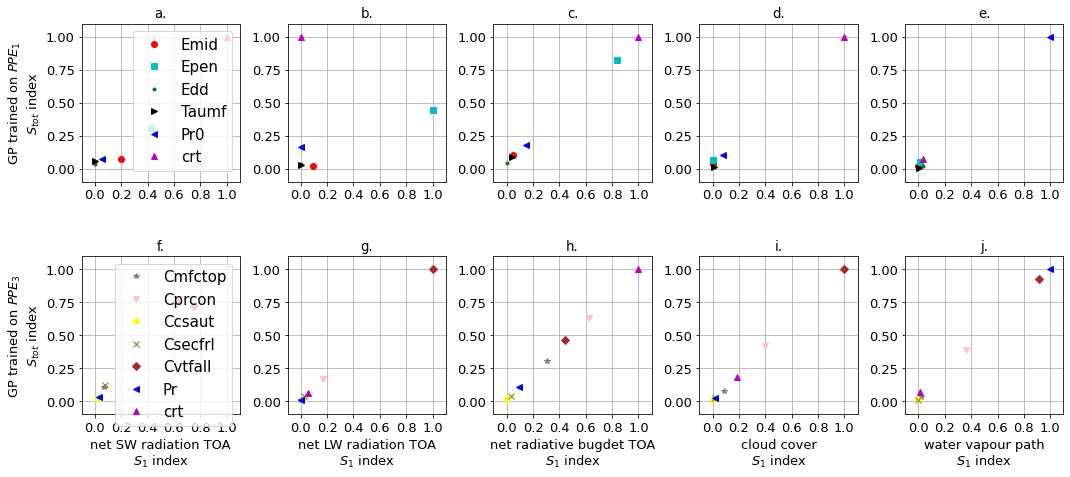

In [60]:
names_metrics=['net SW radiation TOA', 'net LW radiation TOA', 'net radiative bugdet TOA',  'cloud cover','water vapour path']#,'tauu on NAO','tauu on SOO','ua at 60N and 10hPa','ua at 60S and 10hPa']
parameters_list1 =['Emid','Epen','Edd','Taumf', 'Pr0', 'crt']
colors1=['r','c','g','k','b','m']
shapes1=['o','s','.','>','<','^']
parameters_list2=['Cmfctop', 'Cprcon', 'Ccsaut', 'Csecfrl', 'Cvtfall', 'Pr', 'crt']
colors2=['gray','pink','yellow','olive','brown', 'b','m']
shapes2=['*','v','p','x','D', '<','^']
leg_case=[r'$PPE_1$',r'$PPE_1$ and $PPE_2$',r'$PPE_3$',r'$PPE_3$ and $PPE_4$']
letter=['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.']
fontsize=13
plt.rc('font', size=fontsize-2) 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['figure.figsize'] = [15, 8]

fig = plt.figure()
#fig.patch.set_facecolor('white')
nparam=[6,6,7,7]  
iplot=0
ncase=4
for icase in [0,2]: #only PPE1 and PPE3
    if (icase==0 or icase==1):
        param=parameters_list1
        col=colors1
        sha=shapes1
    if (icase==2 or icase==3):
        param=parameters_list2
        col=colors2
        sha=shapes2
    for ioutput in np.arange(noutputs):# 5 outputs
        ax = fig.add_subplot(2,5,iplot+1)
        plt.xlim([-0.1,1.1])
        plt.ylim([-0.1,1.1])
        plt.xticks(np.arange(0.0,1.11,0.2))
        ax.set_aspect('equal')
        for iparam in np.arange(nparam[icase]):
            plt.plot(indicesall[icase][0][ioutput][iparam],indicesall[icase][1][ioutput][iparam],sha[iparam],color=col[iparam],label=param[iparam])
        if iplot in np.arange(0,ncase*noutputs-1,noutputs):
            plt.legend()
            plt.ylabel(r'GP trained on '+leg_case[icase]+'\n'+r'$S_{tot}$ index')   
        #else:
        #    plt.yticks(color='w')     
        #if icase==0:
        #    plt.xticks(color='w')     
        if icase==2 :
            plt.xlabel(names_metrics[ioutput]+'\n'+r'$S_1$ index')    
        
        plt.title(letter[iplot])
        plt.grid()
        iplot+=1
        fig.tight_layout()
#plt.savefig('PaperFig/all_Sobol_indices_PhysicsOutputs_PPE1_PPE3.png')

In [33]:
#convergence study
indices_wrt_samplesize={}
indd=0
size_samples=[1e4,3e4,7e4,10e4,13e4]
#size_samples=[1e4,2e4,3e4,4e4,5e4,6e4,7e4,8e4,9e4,10e4,13e4]
for isize_sample in size_samples:
    #1st, 2nd, 4rd, 5th paper PPEs
    minnall=[minn1,minn12,minn3,minn34]
    maxxall=[maxx1,maxx12,maxx3,maxx34]
    icase=0
    indicesall={}
    nparam=[6,6,7,7]
    noutputs=5 #number of outputs
    for funcc in [func_GP_for_Sobol1,func_GP_for_Sobol12,func_GP_for_Sobol3,func_GP_for_Sobol34]:
        print('icase',icase)
        indices = sobol_original(funcc,minnall[icase],maxxall[icase],70000,nparam[icase], noutputs)
        for ioutput in np.arange(noutputs):
            print('output',ioutput)
            for iparam in np.arange(nparam[icase]):
                print('parameter', iparam,'has a first order Sobol indice of',  round(indices[0][ioutput][iparam], 2), 'and total Sobol indice of', round(indices[1][ioutput][iparam], 2))
        indicesall[icase]=indices
        icase+=1
    indices_wrt_samplesize[indd]=indicesall
    indd+=1

icase 0
output 0
parameter 0 has a first order Sobol indice of 1.27 and total Sobol indice of 0.62
parameter 1 has a first order Sobol indice of -0.9 and total Sobol indice of 2.6
parameter 2 has a first order Sobol indice of -0.01 and total Sobol indice of 0.28
parameter 3 has a first order Sobol indice of -0.27 and total Sobol indice of 0.46
parameter 4 has a first order Sobol indice of 0.77 and total Sobol indice of 0.59
parameter 5 has a first order Sobol indice of 10.82 and total Sobol indice of 8.53
output 1
parameter 0 has a first order Sobol indice of 0.13 and total Sobol indice of 0.01
parameter 1 has a first order Sobol indice of 1.12 and total Sobol indice of 0.23
parameter 2 has a first order Sobol indice of -0.0 and total Sobol indice of 0.02
parameter 3 has a first order Sobol indice of 0.24 and total Sobol indice of 0.01
parameter 4 has a first order Sobol indice of 0.12 and total Sobol indice of 0.08
parameter 5 has a first order Sobol indice of 1.1 and total Sobol indi

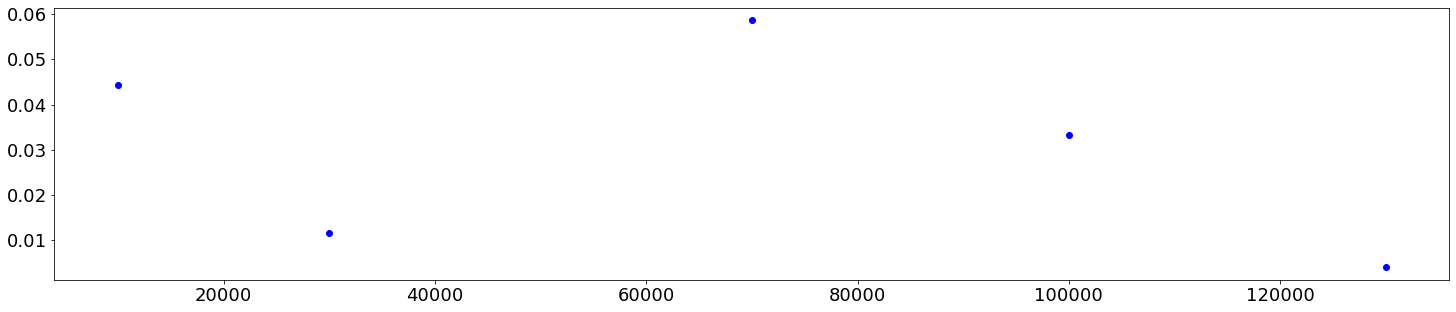

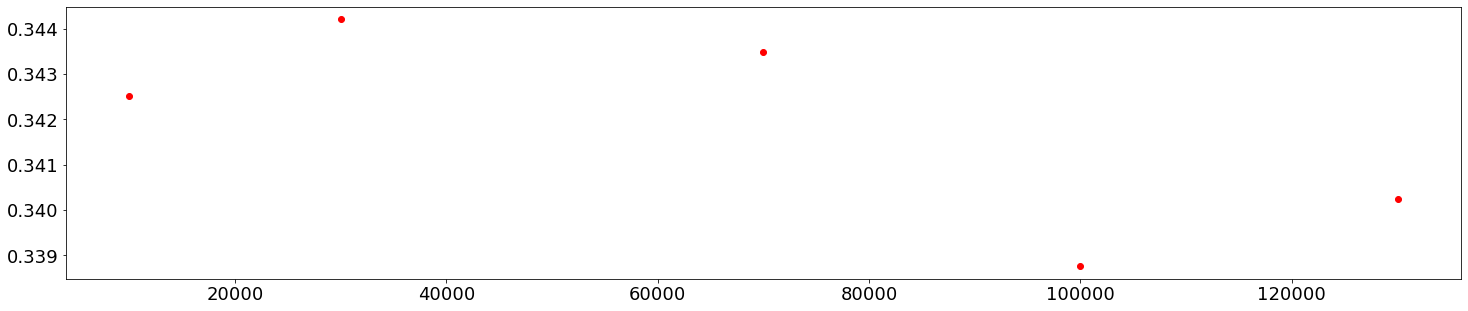

In [48]:
#plot convergence study
icase=2
iout=2
ipar=2
plt.subplots()
for ii in np.arange(len(size_samples)):
    plt.plot(size_samples[ii],indices_wrt_samplesize[ii][icase][0][iout][ipar],'ob',label='1st order Sobol index')

plt.subplots()
for ii in np.arange(len(size_samples)):
    plt.plot(size_samples[ii],indices_wrt_samplesize[ii][icase][1][iout][ipar],'or',label='Total order Sobol index')